##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import json

2023-07-15 17:05:04.159481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 17:05:04.197655: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 17:05:04.198270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 17:05:04.925655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The hidden code cell limits the output height in colab.

In [2]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [3]:
from google.cloud import storage
import io
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/home/ralf/.config/gcloud/application_default_credentials.json"
os.environ['GOOGLE_CLOUD_PROJECT'] = "359515640875"
client = storage.Client()
bucket = client.get_bucket('06fff4a5ff3c1cb7a4089a63899047ff8dcd')
# Then do other things...
blob1 = bucket.get_blob('ROTVRSV')
blob2 = bucket.get_blob('DENV')
in_memory_file1 = io.BytesIO()
blob1.download_to_file(in_memory_file1)
in_memory_file1.seek(0)
in_memory_file2 = io.BytesIO()
blob2.download_to_file(in_memory_file2)
in_memory_file2.seek(0)

0

In [4]:
# Load the dataset
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

# Assuming your dataset is stored in a CSV file
dataset_path = "/home/ralf/IdeaProjects/LitBall-training/EXP-Title+TLDR/"

trds = pd.read_json(in_memory_file1,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
teds = pd.read_json(in_memory_file2,
                 dtype={"preprocessedText": str, "label": str},
                lines=True
                 )
tr_ds = tfdf.keras.pd_dataframe_to_tf_dataset(trds, label="label")
te_ds = tfdf.keras.pd_dataframe_to_tf_dataset(teds, label="label")

with open(dataset_path + "DENV") as file:
    test_lines = file.readlines()

In [5]:
def prepare_dataset1(example, label):
    return {"sentence" : tf.strings.split(example["preprocessedText"])}, label

def prepare_dataset2(s):
    m = json.loads(s)
    sp = tf.strings.split(m["preprocessedText"])
#    print(sp)
#    m["prep"] = tf.RaggedTensor.from_tensor(sp, ragged_rank=1)
#    m["prep"] = tf.constant(sp)
    return m

train_ds = tr_ds.map(prepare_dataset1)
test_ds = te_ds.map(prepare_dataset1)
#for features, label in test_ds:
#    print("features:", features)
#    print("label:", label)
#    break
    
test_cases = list(map(prepare_dataset2, test_lines))

In [6]:
%set_cell_height 300
# Create a Random Search tuner with 50 trials and automatic hp configuration.
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2, num_threads=3, tuner=tuner)

# Train the model.
model_1.fit(x=train_ds, batch_size=None)

<IPython.core.display.Javascript object>

Use /tmp/tmpopzgie9_ as temporary training directory


Reading training dataset...


2023-07-15 17:08:10.579548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [22996]
	 [[{{node Placeholder/_0}}]]


Training tensor examples:
Features: {'sentence': tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64))}
Label: Tensor("data_2:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sentence': SemanticTensor(semantic=<Semantic.CATEGORICAL_SET: 4>, tensor=tf.RaggedTensor(values=Tensor("data:0", shape=(None,), dtype=string), row_splits=Tensor("data_1:0", shape=(None,), dtype=int64)))}
Training dataset read in 0:00:02.329981. Found 22996 examples.
Training model...
Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training gets stuck, try calling tfdf.keras.set_training_logs_redirection(False).


[INFO 23-07-15 17:08:12.9246 CEST kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-15 17:08:12.9247 CEST kernel.cc:774] Collect training examples
[INFO 23-07-15 17:08:12.9247 CEST kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-15 17:08:12.9253 CEST kernel.cc:393] Number of batches: 23
[INFO 23-07-15 17:08:12.9253 CEST kernel.cc:394] Number of examples: 22996
[INFO 23-07-15 17:08:12.9978 CEST data_spec_inference.cc:305] 35489 item(s) have been pruned (i.e. they are considered out of dictionary) for the column sentence (2000 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 23-07-15 17:08:13.0632 CEST

[INFO 23-07-15 17:08:55.7610 CEST random_forest.cc:802] Training of tree  7/300 (tree index:6) done accuracy:0.750964 logloss:4.06576
[INFO 23-07-15 17:09:06.6177 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.763349 logloss:2.95432
[INFO 23-07-15 17:09:07.6684 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.764234 logloss:3.03814
[INFO 23-07-15 17:09:07.8933 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.759231 logloss:3.09187
[INFO 23-07-15 17:09:18.4706 CEST random_forest.cc:802] Training of tree  11/300 (tree index:10) done accuracy:0.770811 logloss:2.2378
[INFO 23-07-15 17:09:19.5713 CEST random_forest.cc:802] Training of tree  11/300 (tree index:10) done accuracy:0.775365 logloss:2.34059
[INFO 23-07-15 17:09:20.4239 CEST random_forest.cc:802] Training of tree  11/300 (tree index:10) done accuracy:0.771686 logloss:2.2909
[INFO 23-07-15 17:09:30.3359 CEST random_forest.cc:802] Tr

[INFO 23-07-15 17:13:01.2257 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.82784 logloss:0.458308
[INFO 23-07-15 17:13:05.0661 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.826622 logloss:0.447056
[INFO 23-07-15 17:13:05.6516 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.826579 logloss:0.446639
[INFO 23-07-15 17:13:12.5233 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.830318 logloss:0.45139
[INFO 23-07-15 17:13:16.6806 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.827666 logloss:0.43932
[INFO 23-07-15 17:13:17.4024 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.827361 logloss:0.442686
[INFO 23-07-15 17:13:24.3732 CEST random_forest.cc:802] Training of tree  53/300 (tree index:52) done accuracy:0.829275 logloss:0.445117
[INFO 23-07-15 17:13:29.0802 CEST random_for

[INFO 23-07-15 17:16:57.0363 CEST random_forest.cc:802] Training of tree  87/300 (tree index:86) done accuracy:0.836667 logloss:0.404352
[INFO 23-07-15 17:17:04.6453 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.835232 logloss:0.401693
[INFO 23-07-15 17:17:08.3003 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.837754 logloss:0.403611
[INFO 23-07-15 17:17:08.6783 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.83658 logloss:0.402466
[INFO 23-07-15 17:17:16.1202 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.835406 logloss:0.400143
[INFO 23-07-15 17:17:20.3433 CEST random_forest.cc:802] Training of tree  93/300 (tree index:92) done accuracy:0.838842 logloss:0.403505
[INFO 23-07-15 17:17:20.4091 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.837798 logloss:0.3991
[INFO 23-07-15 17:17:28.0980 CEST random_for

[INFO 23-07-15 17:20:57.6689 CEST random_forest.cc:802] Training of tree  127/300 (tree index:126) done accuracy:0.839798 logloss:0.393622
[INFO 23-07-15 17:21:02.7232 CEST random_forest.cc:802] Training of tree  131/300 (tree index:130) done accuracy:0.839668 logloss:0.391555
[INFO 23-07-15 17:21:04.4259 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.839537 logloss:0.393369
[INFO 23-07-15 17:21:09.6267 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.840537 logloss:0.393294
[INFO 23-07-15 17:21:14.4363 CEST random_forest.cc:802] Training of tree  133/300 (tree index:132) done accuracy:0.839755 logloss:0.391682
[INFO 23-07-15 17:21:16.1817 CEST random_forest.cc:802] Training of tree  131/300 (tree index:130) done accuracy:0.839189 logloss:0.393195
[INFO 23-07-15 17:21:21.6077 CEST random_forest.cc:802] Training of tree  131/300 (tree index:130) done accuracy:0.841494 logloss:0.39332
[INFO 23-07-15 17:21:25.8705

[INFO 23-07-15 17:24:56.3041 CEST random_forest.cc:802] Training of tree  167/300 (tree index:166) done accuracy:0.84306 logloss:0.389192
[INFO 23-07-15 17:24:57.0380 CEST random_forest.cc:802] Training of tree  171/300 (tree index:170) done accuracy:0.841233 logloss:0.385725
[INFO 23-07-15 17:25:02.8795 CEST random_forest.cc:802] Training of tree  169/300 (tree index:168) done accuracy:0.842712 logloss:0.390277
[INFO 23-07-15 17:25:08.3097 CEST random_forest.cc:802] Training of tree  169/300 (tree index:168) done accuracy:0.842842 logloss:0.389037
[INFO 23-07-15 17:25:08.5834 CEST random_forest.cc:802] Training of tree  173/300 (tree index:172) done accuracy:0.840798 logloss:0.385652
[INFO 23-07-15 17:25:14.7274 CEST random_forest.cc:802] Training of tree  171/300 (tree index:170) done accuracy:0.842842 logloss:0.390259
[INFO 23-07-15 17:25:20.3057 CEST random_forest.cc:802] Training of tree  175/300 (tree index:174) done accuracy:0.840842 logloss:0.385568
[INFO 23-07-15 17:25:20.6839

[INFO 23-07-15 17:28:53.9700 CEST random_forest.cc:802] Training of tree  211/300 (tree index:210) done accuracy:0.840842 logloss:0.385622
[INFO 23-07-15 17:28:57.1443 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.843147 logloss:0.388853
[INFO 23-07-15 17:29:00.5292 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.843842 logloss:0.389879
[INFO 23-07-15 17:29:05.9497 CEST random_forest.cc:802] Training of tree  213/300 (tree index:212) done accuracy:0.840842 logloss:0.385488
[INFO 23-07-15 17:29:09.1453 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.843016 logloss:0.38886
[INFO 23-07-15 17:29:12.4147 CEST random_forest.cc:802] Training of tree  211/300 (tree index:210) done accuracy:0.844364 logloss:0.389931
[INFO 23-07-15 17:29:17.0125 CEST random_forest.cc:802] Training of tree  215/300 (tree index:214) done accuracy:0.841233 logloss:0.385447
[INFO 23-07-15 17:29:20.3207

[INFO 23-07-15 17:32:49.4711 CEST random_forest.cc:802] Training of tree  251/300 (tree index:250) done accuracy:0.842755 logloss:0.384856
[INFO 23-07-15 17:32:53.0817 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.843842 logloss:0.388401
[INFO 23-07-15 17:32:56.5329 CEST random_forest.cc:802] Training of tree  249/300 (tree index:248) done accuracy:0.843581 logloss:0.387931
[INFO 23-07-15 17:33:01.3323 CEST random_forest.cc:802] Training of tree  253/300 (tree index:252) done accuracy:0.841755 logloss:0.384848
[INFO 23-07-15 17:33:04.9896 CEST random_forest.cc:802] Training of tree  249/300 (tree index:248) done accuracy:0.844016 logloss:0.388368
[INFO 23-07-15 17:33:08.3967 CEST random_forest.cc:802] Training of tree  251/300 (tree index:250) done accuracy:0.843147 logloss:0.387835
[INFO 23-07-15 17:33:13.0860 CEST random_forest.cc:802] Training of tree  255/300 (tree index:254) done accuracy:0.841712 logloss:0.384828
[INFO 23-07-15 17:33:16.597

[INFO 23-07-15 17:36:44.9191 CEST random_forest.cc:802] Training of tree  291/300 (tree index:290) done accuracy:0.843625 logloss:0.382814
[INFO 23-07-15 17:36:52.9287 CEST random_forest.cc:802] Training of tree  287/300 (tree index:286) done accuracy:0.845408 logloss:0.387579
[INFO 23-07-15 17:36:54.1738 CEST random_forest.cc:802] Training of tree  289/300 (tree index:288) done accuracy:0.844103 logloss:0.387508
[INFO 23-07-15 17:36:56.3262 CEST random_forest.cc:802] Training of tree  293/300 (tree index:292) done accuracy:0.843799 logloss:0.382768
[INFO 23-07-15 17:37:05.3147 CEST random_forest.cc:802] Training of tree  289/300 (tree index:288) done accuracy:0.845582 logloss:0.38763
[INFO 23-07-15 17:37:05.7585 CEST random_forest.cc:802] Training of tree  291/300 (tree index:290) done accuracy:0.843755 logloss:0.387485
[INFO 23-07-15 17:37:08.4958 CEST random_forest.cc:802] Training of tree  295/300 (tree index:294) done accuracy:0.843495 logloss:0.382689
[INFO 23-07-15 17:37:16.8408

[INFO 23-07-15 17:39:19.4130 CEST random_forest.cc:802] Training of tree  13/300 (tree index:12) done accuracy:0.782685 logloss:1.78852
[INFO 23-07-15 17:39:22.0939 CEST random_forest.cc:802] Training of tree  17/300 (tree index:16) done accuracy:0.793927 logloss:1.10148
[INFO 23-07-15 17:39:28.6433 CEST random_forest.cc:802] Training of tree  13/300 (tree index:12) done accuracy:0.782685 logloss:1.78852
[INFO 23-07-15 17:39:31.3960 CEST random_forest.cc:802] Training of tree  15/300 (tree index:14) done accuracy:0.791008 logloss:1.4482
[INFO 23-07-15 17:39:33.5435 CEST random_forest.cc:802] Training of tree  19/300 (tree index:18) done accuracy:0.797625 logloss:0.959873
[INFO 23-07-15 17:39:40.4897 CEST random_forest.cc:802] Training of tree  15/300 (tree index:14) done accuracy:0.791008 logloss:1.4482
[INFO 23-07-15 17:39:43.2386 CEST random_forest.cc:802] Training of tree  17/300 (tree index:16) done accuracy:0.795058 logloss:1.16057
[INFO 23-07-15 17:39:45.4559 CEST random_forest.c

[INFO 23-07-15 17:43:14.6073 CEST random_forest.cc:802] Training of tree  53/300 (tree index:52) done accuracy:0.831232 logloss:0.43124
[INFO 23-07-15 17:43:17.9815 CEST random_forest.cc:802] Training of tree  57/300 (tree index:56) done accuracy:0.830579 logloss:0.421906
[INFO 23-07-15 17:43:23.6475 CEST random_forest.cc:802] Training of tree  53/300 (tree index:52) done accuracy:0.831232 logloss:0.43124
[INFO 23-07-15 17:43:26.2307 CEST random_forest.cc:802] Training of tree  55/300 (tree index:54) done accuracy:0.831579 logloss:0.427939
[INFO 23-07-15 17:43:29.8154 CEST random_forest.cc:802] Training of tree  59/300 (tree index:58) done accuracy:0.832014 logloss:0.421402
[INFO 23-07-15 17:43:35.3187 CEST random_forest.cc:802] Training of tree  55/300 (tree index:54) done accuracy:0.831579 logloss:0.427939
[INFO 23-07-15 17:43:38.3225 CEST random_forest.cc:802] Training of tree  57/300 (tree index:56) done accuracy:0.831275 logloss:0.426233
[INFO 23-07-15 17:43:41.7549 CEST random_fo

[INFO 23-07-15 17:47:15.9734 CEST random_forest.cc:802] Training of tree  93/300 (tree index:92) done accuracy:0.83758 logloss:0.398881
[INFO 23-07-15 17:47:21.3137 CEST random_forest.cc:802] Training of tree  97/300 (tree index:96) done accuracy:0.83758 logloss:0.393738
[INFO 23-07-15 17:47:26.0018 CEST random_forest.cc:802] Training of tree  93/300 (tree index:92) done accuracy:0.83758 logloss:0.398881
[INFO 23-07-15 17:47:28.7168 CEST random_forest.cc:802] Training of tree  95/300 (tree index:94) done accuracy:0.838363 logloss:0.397458
[INFO 23-07-15 17:47:33.2532 CEST random_forest.cc:802] Training of tree  99/300 (tree index:98) done accuracy:0.837667 logloss:0.39231
[INFO 23-07-15 17:47:38.5797 CEST random_forest.cc:802] Training of tree  95/300 (tree index:94) done accuracy:0.838363 logloss:0.397458
[INFO 23-07-15 17:47:40.7152 CEST random_forest.cc:802] Training of tree  97/300 (tree index:96) done accuracy:0.839276 logloss:0.397217
[INFO 23-07-15 17:47:45.4064 CEST random_fore

[INFO 23-07-15 17:51:14.6903 CEST random_forest.cc:802] Training of tree  133/300 (tree index:132) done accuracy:0.842581 logloss:0.391913
[INFO 23-07-15 17:51:22.4330 CEST random_forest.cc:802] Training of tree  137/300 (tree index:136) done accuracy:0.840059 logloss:0.389223
[INFO 23-07-15 17:51:24.9892 CEST random_forest.cc:802] Training of tree  133/300 (tree index:132) done accuracy:0.842581 logloss:0.391913
[INFO 23-07-15 17:51:26.5874 CEST random_forest.cc:802] Training of tree  135/300 (tree index:134) done accuracy:0.841886 logloss:0.391821
[INFO 23-07-15 17:51:34.1302 CEST random_forest.cc:802] Training of tree  139/300 (tree index:138) done accuracy:0.840407 logloss:0.388915
[INFO 23-07-15 17:51:36.7834 CEST random_forest.cc:802] Training of tree  135/300 (tree index:134) done accuracy:0.841886 logloss:0.391821
[INFO 23-07-15 17:51:37.9169 CEST random_forest.cc:802] Training of tree  137/300 (tree index:136) done accuracy:0.842059 logloss:0.391866
[INFO 23-07-15 17:51:46.058

[INFO 23-07-15 17:55:12.8494 CEST random_forest.cc:802] Training of tree  175/300 (tree index:174) done accuracy:0.842146 logloss:0.38852
[INFO 23-07-15 17:55:23.4740 CEST random_forest.cc:802] Training of tree  173/300 (tree index:172) done accuracy:0.842886 logloss:0.389047
[INFO 23-07-15 17:55:24.2276 CEST random_forest.cc:802] Training of tree  175/300 (tree index:174) done accuracy:0.843495 logloss:0.388874
[INFO 23-07-15 17:55:24.7941 CEST random_forest.cc:802] Training of tree  177/300 (tree index:176) done accuracy:0.842886 logloss:0.388499
[INFO 23-07-15 17:55:35.4406 CEST random_forest.cc:802] Training of tree  175/300 (tree index:174) done accuracy:0.843495 logloss:0.388874
[INFO 23-07-15 17:55:36.0627 CEST random_forest.cc:802] Training of tree  177/300 (tree index:176) done accuracy:0.84419 logloss:0.38878
[INFO 23-07-15 17:55:36.7944 CEST random_forest.cc:802] Training of tree  179/300 (tree index:178) done accuracy:0.841973 logloss:0.388479
[INFO 23-07-15 17:55:47.6009 C

[INFO 23-07-15 17:59:11.8425 CEST random_forest.cc:802] Training of tree  215/300 (tree index:214) done accuracy:0.844582 logloss:0.387384
[INFO 23-07-15 17:59:22.8508 CEST random_forest.cc:802] Training of tree  215/300 (tree index:214) done accuracy:0.844669 logloss:0.388439
[INFO 23-07-15 17:59:23.1962 CEST random_forest.cc:802] Training of tree  213/300 (tree index:212) done accuracy:0.844538 logloss:0.388524
[INFO 23-07-15 17:59:24.0557 CEST random_forest.cc:802] Training of tree  217/300 (tree index:216) done accuracy:0.844234 logloss:0.387256
[INFO 23-07-15 17:59:34.0873 CEST random_forest.cc:802] Training of tree  217/300 (tree index:216) done accuracy:0.844843 logloss:0.388346
[INFO 23-07-15 17:59:34.4219 CEST random_forest.cc:802] Training of tree  215/300 (tree index:214) done accuracy:0.844669 logloss:0.388439
[INFO 23-07-15 17:59:36.2224 CEST random_forest.cc:802] Training of tree  219/300 (tree index:218) done accuracy:0.843886 logloss:0.387223
[INFO 23-07-15 17:59:45.709

[INFO 23-07-15 18:03:13.3453 CEST random_forest.cc:802] Training of tree  255/300 (tree index:254) done accuracy:0.843625 logloss:0.385593
[INFO 23-07-15 18:03:22.3019 CEST random_forest.cc:802] Training of tree  255/300 (tree index:254) done accuracy:0.844582 logloss:0.386832
[INFO 23-07-15 18:03:22.9094 CEST random_forest.cc:802] Training of tree  253/300 (tree index:252) done accuracy:0.844321 logloss:0.386945
[INFO 23-07-15 18:03:25.8903 CEST random_forest.cc:802] Training of tree  257/300 (tree index:256) done accuracy:0.843755 logloss:0.385561
[INFO 23-07-15 18:03:34.5045 CEST random_forest.cc:802] Training of tree  257/300 (tree index:256) done accuracy:0.844625 logloss:0.386842
[INFO 23-07-15 18:03:35.4721 CEST random_forest.cc:802] Training of tree  255/300 (tree index:254) done accuracy:0.844582 logloss:0.386832
[INFO 23-07-15 18:03:38.4423 CEST random_forest.cc:802] Training of tree  259/300 (tree index:258) done accuracy:0.843929 logloss:0.385509
[INFO 23-07-15 18:03:46.784

[INFO 23-07-15 18:07:15.9782 CEST random_forest.cc:802] Training of tree  295/300 (tree index:294) done accuracy:0.845147 logloss:0.385074
[INFO 23-07-15 18:07:25.0052 CEST random_forest.cc:802] Training of tree  295/300 (tree index:294) done accuracy:0.845669 logloss:0.38493
[INFO 23-07-15 18:07:26.5027 CEST random_forest.cc:802] Training of tree  293/300 (tree index:292) done accuracy:0.84519 logloss:0.385009
[INFO 23-07-15 18:07:28.0534 CEST random_forest.cc:802] Training of tree  297/300 (tree index:296) done accuracy:0.845104 logloss:0.385073
[INFO 23-07-15 18:07:37.3927 CEST random_forest.cc:802] Training of tree  297/300 (tree index:296) done accuracy:0.845451 logloss:0.384984
[INFO 23-07-15 18:07:38.4274 CEST random_forest.cc:802] Training of tree  295/300 (tree index:294) done accuracy:0.845669 logloss:0.38493
[INFO 23-07-15 18:07:40.2885 CEST random_forest.cc:802] Training of tree  299/300 (tree index:298) done accuracy:0.844973 logloss:0.385033
[INFO 23-07-15 18:07:46.0376 C

[INFO 23-07-15 18:09:56.5043 CEST random_forest.cc:802] Training of tree  21/300 (tree index:20) done accuracy:0.80207 logloss:0.865766
[INFO 23-07-15 18:09:56.6171 CEST random_forest.cc:802] Training of tree  17/300 (tree index:16) done accuracy:0.796363 logloss:1.11983
[INFO 23-07-15 18:10:06.0792 CEST random_forest.cc:802] Training of tree  21/300 (tree index:20) done accuracy:0.802375 logloss:0.808469
[INFO 23-07-15 18:10:08.4101 CEST random_forest.cc:802] Training of tree  19/300 (tree index:18) done accuracy:0.798974 logloss:0.953489
[INFO 23-07-15 18:10:09.0744 CEST random_forest.cc:802] Training of tree  23/300 (tree index:22) done accuracy:0.804949 logloss:0.768585
[INFO 23-07-15 18:10:19.0714 CEST random_forest.cc:802] Training of tree  23/300 (tree index:22) done accuracy:0.80521 logloss:0.719209
[INFO 23-07-15 18:10:20.8343 CEST random_forest.cc:802] Training of tree  25/300 (tree index:24) done accuracy:0.809576 logloss:0.70122
[INFO 23-07-15 18:10:20.8689 CEST random_fore

[INFO 23-07-15 18:13:54.3556 CEST random_forest.cc:802] Training of tree  61/300 (tree index:60) done accuracy:0.832841 logloss:0.419965
[INFO 23-07-15 18:13:58.6097 CEST random_forest.cc:802] Training of tree  57/300 (tree index:56) done accuracy:0.830057 logloss:0.42148
[INFO 23-07-15 18:14:05.9607 CEST random_forest.cc:802] Training of tree  63/300 (tree index:62) done accuracy:0.833797 logloss:0.418179
[INFO 23-07-15 18:14:06.0986 CEST random_forest.cc:802] Training of tree  61/300 (tree index:60) done accuracy:0.830231 logloss:0.41383
[INFO 23-07-15 18:14:11.1276 CEST random_forest.cc:802] Training of tree  59/300 (tree index:58) done accuracy:0.831753 logloss:0.419558
[INFO 23-07-15 18:14:18.4852 CEST random_forest.cc:802] Training of tree  63/300 (tree index:62) done accuracy:0.830275 logloss:0.413088
[INFO 23-07-15 18:14:18.6154 CEST random_forest.cc:802] Training of tree  65/300 (tree index:64) done accuracy:0.834145 logloss:0.417585
[INFO 23-07-15 18:14:24.1010 CEST random_fo

[INFO 23-07-15 18:18:03.5265 CEST random_forest.cc:802] Training of tree  99/300 (tree index:98) done accuracy:0.836058 logloss:0.392889
[INFO 23-07-15 18:18:07.5861 CEST random_forest.cc:802] Training of tree  97/300 (tree index:96) done accuracy:0.837493 logloss:0.397761
[INFO 23-07-15 18:18:15.1551 CEST random_forest.cc:802] Training of tree  103/300 (tree index:102) done accuracy:0.839015 logloss:0.394829
[INFO 23-07-15 18:18:15.2166 CEST random_forest.cc:802] Training of tree  101/300 (tree index:100) done accuracy:0.836102 logloss:0.392832
[INFO 23-07-15 18:18:19.8394 CEST random_forest.cc:802] Training of tree  99/300 (tree index:98) done accuracy:0.837493 logloss:0.396261
[INFO 23-07-15 18:18:28.1516 CEST random_forest.cc:802] Training of tree  105/300 (tree index:104) done accuracy:0.839233 logloss:0.394557
[INFO 23-07-15 18:18:28.3957 CEST random_forest.cc:802] Training of tree  103/300 (tree index:102) done accuracy:0.835971 logloss:0.392881
[INFO 23-07-15 18:18:31.8679 CEST

[INFO 23-07-15 18:22:02.2008 CEST random_forest.cc:802] Training of tree  141/300 (tree index:140) done accuracy:0.842712 logloss:0.391664
[INFO 23-07-15 18:22:06.8119 CEST random_forest.cc:802] Training of tree  137/300 (tree index:136) done accuracy:0.840711 logloss:0.388617
[INFO 23-07-15 18:22:12.6549 CEST random_forest.cc:802] Training of tree  141/300 (tree index:140) done accuracy:0.837928 logloss:0.390855
[INFO 23-07-15 18:22:14.1055 CEST random_forest.cc:802] Training of tree  143/300 (tree index:142) done accuracy:0.842146 logloss:0.391653
[INFO 23-07-15 18:22:18.4900 CEST random_forest.cc:802] Training of tree  139/300 (tree index:138) done accuracy:0.840798 logloss:0.38695
[INFO 23-07-15 18:22:24.1999 CEST random_forest.cc:802] Training of tree  143/300 (tree index:142) done accuracy:0.838537 logloss:0.390774
[INFO 23-07-15 18:22:26.7055 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.841407 logloss:0.391542
[INFO 23-07-15 18:22:30.4406

[INFO 23-07-15 18:26:16.0207 CEST random_forest.cc:802] Training of tree  179/300 (tree index:178) done accuracy:0.83945 logloss:0.389595
[INFO 23-07-15 18:26:17.9472 CEST random_forest.cc:802] Training of tree  176/300 (tree index:175) done accuracy:0.841973 logloss:0.386498
[INFO 23-07-15 18:26:25.7083 CEST random_forest.cc:802] Training of tree  182/300 (tree index:181) done accuracy:0.843103 logloss:0.38873
[INFO 23-07-15 18:26:28.2059 CEST random_forest.cc:802] Training of tree  181/300 (tree index:180) done accuracy:0.839189 logloss:0.389496
[INFO 23-07-15 18:26:30.2605 CEST random_forest.cc:802] Training of tree  178/300 (tree index:177) done accuracy:0.84232 logloss:0.386432
[INFO 23-07-15 18:26:37.9451 CEST random_forest.cc:802] Training of tree  184/300 (tree index:183) done accuracy:0.843973 logloss:0.388749
[INFO 23-07-15 18:26:40.6822 CEST random_forest.cc:802] Training of tree  183/300 (tree index:182) done accuracy:0.839537 logloss:0.389503
[INFO 23-07-15 18:26:42.1533 C

[INFO 23-07-15 18:30:18.2771 CEST random_forest.cc:802] Training of tree  219/300 (tree index:218) done accuracy:0.840494 logloss:0.387615
[INFO 23-07-15 18:30:19.5573 CEST random_forest.cc:802] Training of tree  216/300 (tree index:215) done accuracy:0.844277 logloss:0.38544
[INFO 23-07-15 18:30:23.3805 CEST random_forest.cc:802] Training of tree  222/300 (tree index:221) done accuracy:0.844147 logloss:0.386994
[INFO 23-07-15 18:30:30.1370 CEST random_forest.cc:802] Training of tree  221/300 (tree index:220) done accuracy:0.84019 logloss:0.387509
[INFO 23-07-15 18:30:31.4375 CEST random_forest.cc:802] Training of tree  218/300 (tree index:217) done accuracy:0.844451 logloss:0.385263
[INFO 23-07-15 18:30:35.1608 CEST random_forest.cc:802] Training of tree  224/300 (tree index:223) done accuracy:0.843842 logloss:0.387034
[INFO 23-07-15 18:30:41.3633 CEST random_forest.cc:802] Training of tree  223/300 (tree index:222) done accuracy:0.839537 logloss:0.386096
[INFO 23-07-15 18:30:43.6499 

[INFO 23-07-15 18:34:18.6631 CEST random_forest.cc:802] Training of tree  259/300 (tree index:258) done accuracy:0.841581 logloss:0.385879
[INFO 23-07-15 18:34:21.0690 CEST random_forest.cc:802] Training of tree  256/300 (tree index:255) done accuracy:0.844451 logloss:0.384981
[INFO 23-07-15 18:34:26.5177 CEST random_forest.cc:802] Training of tree  262/300 (tree index:261) done accuracy:0.844277 logloss:0.386749
[INFO 23-07-15 18:34:30.1962 CEST random_forest.cc:802] Training of tree  261/300 (tree index:260) done accuracy:0.84119 logloss:0.385889
[INFO 23-07-15 18:34:33.5074 CEST random_forest.cc:802] Training of tree  258/300 (tree index:257) done accuracy:0.844799 logloss:0.384949
[INFO 23-07-15 18:34:38.7055 CEST random_forest.cc:802] Training of tree  264/300 (tree index:263) done accuracy:0.844451 logloss:0.386738
[INFO 23-07-15 18:34:41.9191 CEST random_forest.cc:802] Training of tree  263/300 (tree index:262) done accuracy:0.84119 logloss:0.385789
[INFO 23-07-15 18:34:45.6735 

[INFO 23-07-15 18:38:13.9166 CEST hyperparameters_optimizer.cc:582] [7/50] Score: 0.845582 / 0.846191 HParams: fields { name: "split_axis" value { categorical: "SPARSE_OBLIQUE" } } fields { name: "sparse_oblique_projection_density_factor" value { real: 5 } } fields { name: "sparse_oblique_normalization" value { categorical: "MIN_MAX" } } fields { name: "sparse_oblique_weights" value { categorical: "BINARY" } } fields { name: "categorical_algorithm" value { categorical: "RANDOM" } } fields { name: "winner_take_all" value { categorical: "true" } } fields { name: "max_depth" value { integer: 20 } } fields { name: "min_examples" value { integer: 10 } }
[INFO 23-07-15 18:38:13.9171 CEST random_forest.cc:416] Training random forest on 22996 example(s) and 1 feature(s).
[INFO 23-07-15 18:38:19.8046 CEST random_forest.cc:802] Training of tree  1/300 (tree index:0) done accuracy:0.726044 logloss:9.87439
[INFO 23-07-15 18:38:20.4839 CEST random_forest.cc:802] Training of tree  299/300 (tree inde

[INFO 23-07-15 18:40:55.6232 CEST random_forest.cc:802] Training of tree  25/300 (tree index:24) done accuracy:0.808575 logloss:0.645162
[INFO 23-07-15 18:41:06.8865 CEST random_forest.cc:802] Training of tree  23/300 (tree index:22) done accuracy:0.806167 logloss:0.759159
[INFO 23-07-15 18:41:06.9789 CEST random_forest.cc:802] Training of tree  29/300 (tree index:28) done accuracy:0.813837 logloss:0.602212
[INFO 23-07-15 18:41:07.5037 CEST random_forest.cc:802] Training of tree  27/300 (tree index:26) done accuracy:0.811706 logloss:0.603423
[INFO 23-07-15 18:41:18.0386 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.81662 logloss:0.570905
[INFO 23-07-15 18:41:18.3452 CEST random_forest.cc:802] Training of tree  25/300 (tree index:24) done accuracy:0.809532 logloss:0.691956
[INFO 23-07-15 18:41:19.4892 CEST random_forest.cc:802] Training of tree  29/300 (tree index:28) done accuracy:0.812098 logloss:0.576056
[INFO 23-07-15 18:41:29.7884 CEST random_f

[INFO 23-07-15 18:44:55.0383 CEST random_forest.cc:802] Training of tree  65/300 (tree index:64) done accuracy:0.830405 logloss:0.425836
[INFO 23-07-15 18:45:02.7691 CEST random_forest.cc:802] Training of tree  69/300 (tree index:68) done accuracy:0.833536 logloss:0.419372
[INFO 23-07-15 18:45:05.1120 CEST random_forest.cc:802] Training of tree  63/300 (tree index:62) done accuracy:0.829231 logloss:0.418783
[INFO 23-07-15 18:45:07.1237 CEST random_forest.cc:802] Training of tree  67/300 (tree index:66) done accuracy:0.83071 logloss:0.420912
[INFO 23-07-15 18:45:14.9527 CEST random_forest.cc:802] Training of tree  71/300 (tree index:70) done accuracy:0.834015 logloss:0.419212
[INFO 23-07-15 18:45:17.1193 CEST random_forest.cc:802] Training of tree  65/300 (tree index:64) done accuracy:0.829927 logloss:0.415466
[INFO 23-07-15 18:45:19.0850 CEST random_forest.cc:802] Training of tree  69/300 (tree index:68) done accuracy:0.831623 logloss:0.420507
[INFO 23-07-15 18:45:27.3930 CEST random_f

[INFO 23-07-15 18:48:58.2637 CEST random_forest.cc:802] Training of tree  105/300 (tree index:104) done accuracy:0.836928 logloss:0.398152
[INFO 23-07-15 18:49:05.3578 CEST random_forest.cc:802] Training of tree  109/300 (tree index:108) done accuracy:0.836972 logloss:0.404347
[INFO 23-07-15 18:49:08.2250 CEST random_forest.cc:802] Training of tree  103/300 (tree index:102) done accuracy:0.836319 logloss:0.400531
[INFO 23-07-15 18:49:10.1972 CEST random_forest.cc:802] Training of tree  107/300 (tree index:106) done accuracy:0.837711 logloss:0.397964
[INFO 23-07-15 18:49:17.2307 CEST random_forest.cc:802] Training of tree  111/300 (tree index:110) done accuracy:0.83758 logloss:0.402817
[INFO 23-07-15 18:49:20.6619 CEST random_forest.cc:802] Training of tree  105/300 (tree index:104) done accuracy:0.836711 logloss:0.400421
[INFO 23-07-15 18:49:22.3406 CEST random_forest.cc:802] Training of tree  109/300 (tree index:108) done accuracy:0.837711 logloss:0.398128
[INFO 23-07-15 18:49:29.0589

[INFO 23-07-15 18:52:58.4596 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.840146 logloss:0.38908
[INFO 23-07-15 18:53:02.1808 CEST random_forest.cc:802] Training of tree  149/300 (tree index:148) done accuracy:0.840451 logloss:0.389235
[INFO 23-07-15 18:53:09.3997 CEST random_forest.cc:802] Training of tree  143/300 (tree index:142) done accuracy:0.840451 logloss:0.392587
[INFO 23-07-15 18:53:11.0285 CEST random_forest.cc:802] Training of tree  147/300 (tree index:146) done accuracy:0.840364 logloss:0.388903
[INFO 23-07-15 18:53:14.6035 CEST random_forest.cc:802] Training of tree  151/300 (tree index:150) done accuracy:0.840842 logloss:0.387861
[INFO 23-07-15 18:53:21.4152 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.840711 logloss:0.39247
[INFO 23-07-15 18:53:22.7494 CEST random_forest.cc:802] Training of tree  149/300 (tree index:148) done accuracy:0.840972 logloss:0.38889
[INFO 23-07-15 18:53:26.5425 C

[INFO 23-07-15 18:56:59.2835 CEST random_forest.cc:802] Training of tree  185/300 (tree index:184) done accuracy:0.841016 logloss:0.387723
[INFO 23-07-15 18:57:02.3947 CEST random_forest.cc:802] Training of tree  189/300 (tree index:188) done accuracy:0.841625 logloss:0.385376
[INFO 23-07-15 18:57:11.3956 CEST random_forest.cc:802] Training of tree  183/300 (tree index:182) done accuracy:0.84219 logloss:0.390114
[INFO 23-07-15 18:57:11.4957 CEST random_forest.cc:802] Training of tree  187/300 (tree index:186) done accuracy:0.841103 logloss:0.387688
[INFO 23-07-15 18:57:14.3548 CEST random_forest.cc:802] Training of tree  191/300 (tree index:190) done accuracy:0.841538 logloss:0.385471
[INFO 23-07-15 18:57:23.0775 CEST random_forest.cc:802] Training of tree  185/300 (tree index:184) done accuracy:0.842494 logloss:0.390036
[INFO 23-07-15 18:57:23.6173 CEST random_forest.cc:802] Training of tree  189/300 (tree index:188) done accuracy:0.840885 logloss:0.387526
[INFO 23-07-15 18:57:26.2591

[INFO 23-07-15 19:01:09.6852 CEST random_forest.cc:802] Training of tree  225/300 (tree index:224) done accuracy:0.841842 logloss:0.386821
[INFO 23-07-15 19:01:09.7362 CEST random_forest.cc:802] Training of tree  221/300 (tree index:220) done accuracy:0.843321 logloss:0.389282
[INFO 23-07-15 19:01:19.8059 CEST random_forest.cc:802] Training of tree  231/300 (tree index:230) done accuracy:0.844582 logloss:0.384643
[INFO 23-07-15 19:01:21.3247 CEST random_forest.cc:802] Training of tree  227/300 (tree index:226) done accuracy:0.842929 logloss:0.386705
[INFO 23-07-15 19:01:21.3687 CEST random_forest.cc:802] Training of tree  223/300 (tree index:222) done accuracy:0.84406 logloss:0.389159
[INFO 23-07-15 19:01:31.8594 CEST random_forest.cc:802] Training of tree  233/300 (tree index:232) done accuracy:0.844234 logloss:0.384568
[INFO 23-07-15 19:01:33.2880 CEST random_forest.cc:802] Training of tree  225/300 (tree index:224) done accuracy:0.84306 logloss:0.389127
[INFO 23-07-15 19:01:33.5318 

[INFO 23-07-15 19:05:12.4641 CEST random_forest.cc:802] Training of tree  269/300 (tree index:268) done accuracy:0.845843 logloss:0.383811
[INFO 23-07-15 19:05:14.7057 CEST random_forest.cc:802] Training of tree  265/300 (tree index:264) done accuracy:0.844234 logloss:0.385997
[INFO 23-07-15 19:05:24.3580 CEST random_forest.cc:802] Training of tree  263/300 (tree index:262) done accuracy:0.843886 logloss:0.387883
[INFO 23-07-15 19:05:24.4196 CEST random_forest.cc:802] Training of tree  271/300 (tree index:270) done accuracy:0.84606 logloss:0.383826
[INFO 23-07-15 19:05:26.4573 CEST random_forest.cc:802] Training of tree  267/300 (tree index:266) done accuracy:0.845451 logloss:0.386018
[INFO 23-07-15 19:05:36.4882 CEST random_forest.cc:802] Training of tree  273/300 (tree index:272) done accuracy:0.845756 logloss:0.383706
[INFO 23-07-15 19:05:36.6561 CEST random_forest.cc:802] Training of tree  265/300 (tree index:264) done accuracy:0.843668 logloss:0.387902
[INFO 23-07-15 19:05:38.4513

[INFO 23-07-15 19:08:42.2015 CEST random_forest.cc:802] Training of tree  299/300 (tree index:298) done accuracy:0.845277 logloss:0.38561
[INFO 23-07-15 19:08:47.9963 CEST random_forest.cc:802] Training of tree  300/300 (tree index:299) done accuracy:0.845234 logloss:0.385578
[INFO 23-07-15 19:08:47.9964 CEST random_forest.cc:882] Final OOB metrics: accuracy:0.845234 logloss:0.385578
[INFO 23-07-15 19:08:48.0497 CEST hyperparameters_optimizer.cc:582] [11/50] Score: 0.845234 / 0.846191 HParams: fields { name: "split_axis" value { categorical: "SPARSE_OBLIQUE" } } fields { name: "sparse_oblique_projection_density_factor" value { real: 4 } } fields { name: "sparse_oblique_normalization" value { categorical: "STANDARD_DEVIATION" } } fields { name: "sparse_oblique_weights" value { categorical: "CONTINUOUS" } } fields { name: "categorical_algorithm" value { categorical: "RANDOM" } } fields { name: "winner_take_all" value { categorical: "true" } } fields { name: "max_depth" value { integer: 1

[INFO 23-07-15 19:11:58.5989 CEST random_forest.cc:802] Training of tree  35/300 (tree index:34) done accuracy:0.820708 logloss:0.520787
[INFO 23-07-15 19:12:00.4107 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.81662 logloss:0.570905
[INFO 23-07-15 19:12:01.0830 CEST random_forest.cc:802] Training of tree  27/300 (tree index:26) done accuracy:0.810445 logloss:0.657393
[INFO 23-07-15 19:12:10.9286 CEST random_forest.cc:802] Training of tree  37/300 (tree index:36) done accuracy:0.823013 logloss:0.50323
[INFO 23-07-15 19:12:12.0114 CEST random_forest.cc:802] Training of tree  33/300 (tree index:32) done accuracy:0.819142 logloss:0.547584
[INFO 23-07-15 19:12:13.9615 CEST random_forest.cc:802] Training of tree  29/300 (tree index:28) done accuracy:0.813489 logloss:0.604399
[INFO 23-07-15 19:12:22.5487 CEST random_forest.cc:802] Training of tree  39/300 (tree index:38) done accuracy:0.823317 logloss:0.491603
[INFO 23-07-15 19:12:23.9145 CEST random_fo

[INFO 23-07-15 19:16:03.8397 CEST random_forest.cc:802] Training of tree  75/300 (tree index:74) done accuracy:0.835058 logloss:0.416581
[INFO 23-07-15 19:16:04.3039 CEST random_forest.cc:802] Training of tree  67/300 (tree index:66) done accuracy:0.834232 logloss:0.42477
[INFO 23-07-15 19:16:05.0996 CEST random_forest.cc:802] Training of tree  71/300 (tree index:70) done accuracy:0.834015 logloss:0.419212
[INFO 23-07-15 19:16:16.1416 CEST random_forest.cc:802] Training of tree  77/300 (tree index:76) done accuracy:0.835015 logloss:0.413498
[INFO 23-07-15 19:16:17.3324 CEST random_forest.cc:802] Training of tree  69/300 (tree index:68) done accuracy:0.833884 logloss:0.421741
[INFO 23-07-15 19:16:17.9966 CEST random_forest.cc:802] Training of tree  73/300 (tree index:72) done accuracy:0.833449 logloss:0.417522
[INFO 23-07-15 19:16:28.1593 CEST random_forest.cc:802] Training of tree  79/300 (tree index:78) done accuracy:0.835667 logloss:0.41277
[INFO 23-07-15 19:16:29.8848 CEST random_fo

[INFO 23-07-15 19:20:03.1087 CEST random_forest.cc:802] Training of tree  115/300 (tree index:114) done accuracy:0.841886 logloss:0.399848
[INFO 23-07-15 19:20:04.8990 CEST random_forest.cc:802] Training of tree  111/300 (tree index:110) done accuracy:0.83758 logloss:0.402817
[INFO 23-07-15 19:20:08.1612 CEST random_forest.cc:802] Training of tree  107/300 (tree index:106) done accuracy:0.840364 logloss:0.400568
[INFO 23-07-15 19:20:14.8932 CEST random_forest.cc:802] Training of tree  117/300 (tree index:116) done accuracy:0.842233 logloss:0.399536
[INFO 23-07-15 19:20:16.6997 CEST random_forest.cc:802] Training of tree  113/300 (tree index:112) done accuracy:0.837363 logloss:0.401195
[INFO 23-07-15 19:20:20.7188 CEST random_forest.cc:802] Training of tree  109/300 (tree index:108) done accuracy:0.840494 logloss:0.400366
[INFO 23-07-15 19:20:26.5432 CEST random_forest.cc:802] Training of tree  119/300 (tree index:118) done accuracy:0.842668 logloss:0.399368
[INFO 23-07-15 19:20:28.8048

[INFO 23-07-15 19:24:00.2428 CEST random_forest.cc:802] Training of tree  155/300 (tree index:154) done accuracy:0.841059 logloss:0.389772
[INFO 23-07-15 19:24:03.3741 CEST random_forest.cc:802] Training of tree  151/300 (tree index:150) done accuracy:0.840842 logloss:0.387861
[INFO 23-07-15 19:24:04.6092 CEST random_forest.cc:802] Training of tree  147/300 (tree index:146) done accuracy:0.842451 logloss:0.391467
[INFO 23-07-15 19:24:12.2988 CEST random_forest.cc:802] Training of tree  157/300 (tree index:156) done accuracy:0.841538 logloss:0.389643
[INFO 23-07-15 19:24:15.2605 CEST random_forest.cc:802] Training of tree  153/300 (tree index:152) done accuracy:0.840277 logloss:0.387839
[INFO 23-07-15 19:24:16.4759 CEST random_forest.cc:802] Training of tree  149/300 (tree index:148) done accuracy:0.842146 logloss:0.391412
[INFO 23-07-15 19:24:24.4654 CEST random_forest.cc:802] Training of tree  159/300 (tree index:158) done accuracy:0.84119 logloss:0.389542
[INFO 23-07-15 19:24:27.2154

[INFO 23-07-15 19:28:02.1947 CEST random_forest.cc:802] Training of tree  191/300 (tree index:190) done accuracy:0.841538 logloss:0.385471
[INFO 23-07-15 19:28:03.4391 CEST random_forest.cc:802] Training of tree  195/300 (tree index:194) done accuracy:0.842973 logloss:0.387267
[INFO 23-07-15 19:28:07.5036 CEST random_forest.cc:802] Training of tree  187/300 (tree index:186) done accuracy:0.843668 logloss:0.387352
[INFO 23-07-15 19:28:14.0262 CEST random_forest.cc:802] Training of tree  193/300 (tree index:192) done accuracy:0.841059 logloss:0.385474
[INFO 23-07-15 19:28:15.4045 CEST random_forest.cc:802] Training of tree  197/300 (tree index:196) done accuracy:0.842929 logloss:0.387147
[INFO 23-07-15 19:28:19.6721 CEST random_forest.cc:802] Training of tree  189/300 (tree index:188) done accuracy:0.842886 logloss:0.387333
[INFO 23-07-15 19:28:26.1780 CEST random_forest.cc:802] Training of tree  195/300 (tree index:194) done accuracy:0.841016 logloss:0.385365
[INFO 23-07-15 19:28:27.733

[INFO 23-07-15 19:31:59.7557 CEST random_forest.cc:802] Training of tree  231/300 (tree index:230) done accuracy:0.844582 logloss:0.384643
[INFO 23-07-15 19:32:01.9384 CEST random_forest.cc:802] Training of tree  235/300 (tree index:234) done accuracy:0.843799 logloss:0.387272
[INFO 23-07-15 19:32:05.1304 CEST random_forest.cc:802] Training of tree  227/300 (tree index:226) done accuracy:0.843755 logloss:0.387098
[INFO 23-07-15 19:32:11.7770 CEST random_forest.cc:802] Training of tree  233/300 (tree index:232) done accuracy:0.844234 logloss:0.384568
[INFO 23-07-15 19:32:13.4859 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.844147 logloss:0.387249
[INFO 23-07-15 19:32:17.3106 CEST random_forest.cc:802] Training of tree  229/300 (tree index:228) done accuracy:0.843538 logloss:0.387121
[INFO 23-07-15 19:32:23.5942 CEST random_forest.cc:802] Training of tree  235/300 (tree index:234) done accuracy:0.845277 logloss:0.384519
[INFO 23-07-15 19:32:24.922

[INFO 23-07-15 19:35:59.3407 CEST random_forest.cc:802] Training of tree  271/300 (tree index:270) done accuracy:0.84606 logloss:0.383826
[INFO 23-07-15 19:36:01.7978 CEST random_forest.cc:802] Training of tree  275/300 (tree index:274) done accuracy:0.844625 logloss:0.386445
[INFO 23-07-15 19:36:05.0785 CEST random_forest.cc:802] Training of tree  267/300 (tree index:266) done accuracy:0.844756 logloss:0.386697
[INFO 23-07-15 19:36:11.2429 CEST random_forest.cc:802] Training of tree  273/300 (tree index:272) done accuracy:0.845756 logloss:0.383706
[INFO 23-07-15 19:36:14.2597 CEST random_forest.cc:802] Training of tree  277/300 (tree index:276) done accuracy:0.844886 logloss:0.386463
[INFO 23-07-15 19:36:16.5842 CEST random_forest.cc:802] Training of tree  269/300 (tree index:268) done accuracy:0.844408 logloss:0.386614
[INFO 23-07-15 19:36:22.9304 CEST random_forest.cc:802] Training of tree  275/300 (tree index:274) done accuracy:0.845756 logloss:0.383673
[INFO 23-07-15 19:36:26.0640

[INFO 23-07-15 19:38:59.2570 CEST random_forest.cc:802] Training of tree  5/300 (tree index:4) done accuracy:0.739042 logloss:5.65902
[INFO 23-07-15 19:38:59.6939 CEST random_forest.cc:802] Training of tree  1/300 (tree index:0) done accuracy:0.726044 logloss:9.87439
[INFO 23-07-15 19:39:02.8707 CEST random_forest.cc:802] Training of tree  297/300 (tree index:296) done accuracy:0.846104 logloss:0.386243
[INFO 23-07-15 19:39:11.1161 CEST random_forest.cc:802] Training of tree  7/300 (tree index:6) done accuracy:0.752052 logloss:4.12997
[INFO 23-07-15 19:39:11.5780 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.728193 logloss:7.62558
[INFO 23-07-15 19:39:14.7982 CEST random_forest.cc:802] Training of tree  299/300 (tree index:298) done accuracy:0.846321 logloss:0.386234
[INFO 23-07-15 19:39:20.3917 CEST random_forest.cc:802] Training of tree  300/300 (tree index:299) done accuracy:0.846626 logloss:0.386248
[INFO 23-07-15 19:39:20.3920 CEST random_forest

[INFO 23-07-15 19:42:21.5304 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.816577 logloss:0.571371
[INFO 23-07-15 19:42:30.1883 CEST random_forest.cc:802] Training of tree  41/300 (tree index:40) done accuracy:0.823752 logloss:0.507729
[INFO 23-07-15 19:42:32.5315 CEST random_forest.cc:802] Training of tree  37/300 (tree index:36) done accuracy:0.820143 logloss:0.544477
[INFO 23-07-15 19:42:32.8690 CEST random_forest.cc:802] Training of tree  33/300 (tree index:32) done accuracy:0.819142 logloss:0.534336
[INFO 23-07-15 19:42:41.3486 CEST random_forest.cc:802] Training of tree  43/300 (tree index:42) done accuracy:0.825274 logloss:0.498591
[INFO 23-07-15 19:42:44.0550 CEST random_forest.cc:802] Training of tree  39/300 (tree index:38) done accuracy:0.820925 logloss:0.530836
[INFO 23-07-15 19:42:44.3804 CEST random_forest.cc:802] Training of tree  35/300 (tree index:34) done accuracy:0.81849 logloss:0.51979
[INFO 23-07-15 19:42:53.2769 CEST random_fo

[INFO 23-07-15 19:46:28.1138 CEST random_forest.cc:802] Training of tree  75/300 (tree index:74) done accuracy:0.834058 logloss:0.422708
[INFO 23-07-15 19:46:37.0528 CEST random_forest.cc:802] Training of tree  73/300 (tree index:72) done accuracy:0.833449 logloss:0.418248
[INFO 23-07-15 19:46:38.0321 CEST random_forest.cc:802] Training of tree  81/300 (tree index:80) done accuracy:0.834623 logloss:0.419306
[INFO 23-07-15 19:46:41.1888 CEST random_forest.cc:802] Training of tree  77/300 (tree index:76) done accuracy:0.83458 logloss:0.422503
[INFO 23-07-15 19:46:50.6482 CEST random_forest.cc:802] Training of tree  75/300 (tree index:74) done accuracy:0.832797 logloss:0.416714
[INFO 23-07-15 19:46:50.9975 CEST random_forest.cc:802] Training of tree  83/300 (tree index:82) done accuracy:0.83545 logloss:0.419036
[INFO 23-07-15 19:46:54.0797 CEST random_forest.cc:802] Training of tree  79/300 (tree index:78) done accuracy:0.835276 logloss:0.421124
[INFO 23-07-15 19:47:03.8832 CEST random_fo

[INFO 23-07-15 19:50:53.7949 CEST random_forest.cc:802] Training of tree  115/300 (tree index:114) done accuracy:0.837624 logloss:0.401778
[INFO 23-07-15 19:50:59.8576 CEST random_forest.cc:802] Training of tree  113/300 (tree index:112) done accuracy:0.83832 logloss:0.400039
[INFO 23-07-15 19:51:03.7873 CEST random_forest.cc:802] Training of tree  121/300 (tree index:120) done accuracy:0.838233 logloss:0.399533
[INFO 23-07-15 19:51:07.1961 CEST random_forest.cc:802] Training of tree  117/300 (tree index:116) done accuracy:0.837972 logloss:0.400005
[INFO 23-07-15 19:51:12.4131 CEST random_forest.cc:802] Training of tree  115/300 (tree index:114) done accuracy:0.838407 logloss:0.398669
[INFO 23-07-15 19:51:16.4098 CEST random_forest.cc:802] Training of tree  123/300 (tree index:122) done accuracy:0.837493 logloss:0.399575
[INFO 23-07-15 19:51:20.0214 CEST random_forest.cc:802] Training of tree  119/300 (tree index:118) done accuracy:0.838102 logloss:0.399815
[INFO 23-07-15 19:51:25.5882

[INFO 23-07-15 19:55:17.6314 CEST random_forest.cc:802] Training of tree  155/300 (tree index:154) done accuracy:0.83945 logloss:0.391476
[INFO 23-07-15 19:55:21.7201 CEST random_forest.cc:802] Training of tree  153/300 (tree index:152) done accuracy:0.840624 logloss:0.392637
[INFO 23-07-15 19:55:27.0177 CEST random_forest.cc:802] Training of tree  161/300 (tree index:160) done accuracy:0.838972 logloss:0.391014
[INFO 23-07-15 19:55:30.9236 CEST random_forest.cc:802] Training of tree  157/300 (tree index:156) done accuracy:0.838842 logloss:0.391393
[INFO 23-07-15 19:55:34.5782 CEST random_forest.cc:802] Training of tree  155/300 (tree index:154) done accuracy:0.840624 logloss:0.392608
[INFO 23-07-15 19:55:39.7413 CEST random_forest.cc:802] Training of tree  163/300 (tree index:162) done accuracy:0.839102 logloss:0.390961
[INFO 23-07-15 19:55:44.6445 CEST random_forest.cc:802] Training of tree  159/300 (tree index:158) done accuracy:0.838972 logloss:0.391204
[INFO 23-07-15 19:55:47.9555

[INFO 23-07-15 19:59:42.4944 CEST random_forest.cc:802] Training of tree  195/300 (tree index:194) done accuracy:0.840798 logloss:0.390213
[INFO 23-07-15 19:59:44.3813 CEST random_forest.cc:802] Training of tree  193/300 (tree index:192) done accuracy:0.840972 logloss:0.390399
[INFO 23-07-15 19:59:50.4470 CEST random_forest.cc:802] Training of tree  201/300 (tree index:200) done accuracy:0.841103 logloss:0.389969
[INFO 23-07-15 19:59:55.8437 CEST random_forest.cc:802] Training of tree  197/300 (tree index:196) done accuracy:0.84132 logloss:0.390181
[INFO 23-07-15 19:59:57.4886 CEST random_forest.cc:802] Training of tree  195/300 (tree index:194) done accuracy:0.840451 logloss:0.390363
[INFO 23-07-15 20:00:03.5411 CEST random_forest.cc:802] Training of tree  203/300 (tree index:202) done accuracy:0.841799 logloss:0.389964
[INFO 23-07-15 20:00:08.8903 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.841016 logloss:0.390155
[INFO 23-07-15 20:00:10.9193

[INFO 23-07-15 20:04:01.9658 CEST random_forest.cc:802] Training of tree  233/300 (tree index:232) done accuracy:0.840972 logloss:0.387246
[INFO 23-07-15 20:04:02.9053 CEST random_forest.cc:802] Training of tree  235/300 (tree index:234) done accuracy:0.842407 logloss:0.389747
[INFO 23-07-15 20:04:11.3577 CEST random_forest.cc:802] Training of tree  241/300 (tree index:240) done accuracy:0.842581 logloss:0.389642
[INFO 23-07-15 20:04:13.7376 CEST random_forest.cc:802] Training of tree  235/300 (tree index:234) done accuracy:0.841103 logloss:0.387183
[INFO 23-07-15 20:04:15.7144 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.84232 logloss:0.389644
[INFO 23-07-15 20:04:23.5839 CEST random_forest.cc:802] Training of tree  243/300 (tree index:242) done accuracy:0.842799 logloss:0.389637
[INFO 23-07-15 20:04:25.4509 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.841451 logloss:0.387084
[INFO 23-07-15 20:04:27.9337

[INFO 23-07-15 20:08:07.0907 CEST random_forest.cc:802] Training of tree  279/300 (tree index:278) done accuracy:0.844147 logloss:0.387786
[INFO 23-07-15 20:08:07.7857 CEST random_forest.cc:802] Training of tree  273/300 (tree index:272) done accuracy:0.842755 logloss:0.386359
[INFO 23-07-15 20:08:11.2095 CEST random_forest.cc:802] Training of tree  275/300 (tree index:274) done accuracy:0.843929 logloss:0.387855
[INFO 23-07-15 20:08:19.1359 CEST random_forest.cc:802] Training of tree  281/300 (tree index:280) done accuracy:0.843103 logloss:0.387809
[INFO 23-07-15 20:08:20.0698 CEST random_forest.cc:802] Training of tree  275/300 (tree index:274) done accuracy:0.842973 logloss:0.386313
[INFO 23-07-15 20:08:23.6684 CEST random_forest.cc:802] Training of tree  277/300 (tree index:276) done accuracy:0.843755 logloss:0.387826
[INFO 23-07-15 20:08:31.5709 CEST random_forest.cc:802] Training of tree  283/300 (tree index:282) done accuracy:0.843625 logloss:0.38782
[INFO 23-07-15 20:08:32.4456

[INFO 23-07-15 20:10:55.0774 CEST random_forest.cc:416] Training random forest on 22996 example(s) and 1 feature(s).
[INFO 23-07-15 20:11:00.9747 CEST random_forest.cc:802] Training of tree  7/300 (tree index:6) done accuracy:0.750692 logloss:4.16532
[INFO 23-07-15 20:11:01.1009 CEST random_forest.cc:802] Training of tree  1/300 (tree index:0) done accuracy:0.725095 logloss:9.90858
[INFO 23-07-15 20:11:03.3527 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.736565 logloss:7.385
[INFO 23-07-15 20:11:13.5046 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.761534 logloss:3.10302
[INFO 23-07-15 20:11:13.7337 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.72673 logloss:7.61815
[INFO 23-07-15 20:11:15.9345 CEST random_forest.cc:802] Training of tree  5/300 (tree index:4) done accuracy:0.747992 logloss:5.47644
[INFO 23-07-15 20:11:25.9397 CEST random_forest.cc:802] Training of tree  11/300 (

[INFO 23-07-15 20:15:09.0352 CEST random_forest.cc:802] Training of tree  47/300 (tree index:46) done accuracy:0.827231 logloss:0.452323
[INFO 23-07-15 20:15:11.7981 CEST random_forest.cc:802] Training of tree  43/300 (tree index:42) done accuracy:0.824622 logloss:0.47519
[INFO 23-07-15 20:15:12.5729 CEST random_forest.cc:802] Training of tree  41/300 (tree index:40) done accuracy:0.825144 logloss:0.473845
[INFO 23-07-15 20:15:21.9468 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.827057 logloss:0.449032
[INFO 23-07-15 20:15:24.5272 CEST random_forest.cc:802] Training of tree  45/300 (tree index:44) done accuracy:0.825144 logloss:0.465583
[INFO 23-07-15 20:15:24.8977 CEST random_forest.cc:802] Training of tree  43/300 (tree index:42) done accuracy:0.826839 logloss:0.466328
[INFO 23-07-15 20:15:35.4563 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.828274 logloss:0.440817
[INFO 23-07-15 20:15:37.5092 CEST random_f

[INFO 23-07-15 20:19:32.9983 CEST random_forest.cc:802] Training of tree  83/300 (tree index:82) done accuracy:0.834189 logloss:0.412589
[INFO 23-07-15 20:19:33.6207 CEST random_forest.cc:802] Training of tree  87/300 (tree index:86) done accuracy:0.835537 logloss:0.413993
[INFO 23-07-15 20:19:35.7499 CEST random_forest.cc:802] Training of tree  81/300 (tree index:80) done accuracy:0.836711 logloss:0.412701
[INFO 23-07-15 20:19:46.2513 CEST random_forest.cc:802] Training of tree  85/300 (tree index:84) done accuracy:0.834928 logloss:0.410831
[INFO 23-07-15 20:19:46.7408 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.835319 logloss:0.409584
[INFO 23-07-15 20:19:49.1944 CEST random_forest.cc:802] Training of tree  83/300 (tree index:82) done accuracy:0.837841 logloss:0.412633
[INFO 23-07-15 20:19:59.0723 CEST random_forest.cc:802] Training of tree  87/300 (tree index:86) done accuracy:0.834884 logloss:0.410725
[INFO 23-07-15 20:19:59.7953 CEST random_

[INFO 23-07-15 20:23:51.4959 CEST random_forest.cc:802] Training of tree  123/300 (tree index:122) done accuracy:0.83832 logloss:0.396764
[INFO 23-07-15 20:23:56.3161 CEST random_forest.cc:802] Training of tree  127/300 (tree index:126) done accuracy:0.838059 logloss:0.396082
[INFO 23-07-15 20:23:59.3513 CEST random_forest.cc:802] Training of tree  121/300 (tree index:120) done accuracy:0.841973 logloss:0.399165
[INFO 23-07-15 20:24:04.3819 CEST random_forest.cc:802] Training of tree  125/300 (tree index:124) done accuracy:0.838972 logloss:0.395158
[INFO 23-07-15 20:24:08.9018 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.838146 logloss:0.395708
[INFO 23-07-15 20:24:11.6635 CEST random_forest.cc:802] Training of tree  123/300 (tree index:122) done accuracy:0.84232 logloss:0.399316
[INFO 23-07-15 20:24:17.7390 CEST random_forest.cc:802] Training of tree  127/300 (tree index:126) done accuracy:0.838929 logloss:0.395115
[INFO 23-07-15 20:24:21.9469 

[INFO 23-07-15 20:28:06.7863 CEST random_forest.cc:802] Training of tree  163/300 (tree index:162) done accuracy:0.840407 logloss:0.392271
[INFO 23-07-15 20:28:12.6454 CEST random_forest.cc:802] Training of tree  167/300 (tree index:166) done accuracy:0.841842 logloss:0.387416
[INFO 23-07-15 20:28:15.8601 CEST random_forest.cc:802] Training of tree  161/300 (tree index:160) done accuracy:0.84132 logloss:0.389495
[INFO 23-07-15 20:28:19.7110 CEST random_forest.cc:802] Training of tree  165/300 (tree index:164) done accuracy:0.840798 logloss:0.392252
[INFO 23-07-15 20:28:24.9078 CEST random_forest.cc:802] Training of tree  169/300 (tree index:168) done accuracy:0.841364 logloss:0.387312
[INFO 23-07-15 20:28:28.6671 CEST random_forest.cc:802] Training of tree  163/300 (tree index:162) done accuracy:0.841755 logloss:0.389255
[INFO 23-07-15 20:28:32.9516 CEST random_forest.cc:802] Training of tree  167/300 (tree index:166) done accuracy:0.840277 logloss:0.392228
[INFO 23-07-15 20:28:37.5868

[INFO 23-07-15 20:32:13.7768 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.842625 logloss:0.387098
[INFO 23-07-15 20:32:19.2256 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.842755 logloss:0.385078
[INFO 23-07-15 20:32:25.5030 CEST random_forest.cc:802] Training of tree  205/300 (tree index:204) done accuracy:0.841712 logloss:0.390341
[INFO 23-07-15 20:32:25.7858 CEST random_forest.cc:802] Training of tree  201/300 (tree index:200) done accuracy:0.843103 logloss:0.387066
[INFO 23-07-15 20:32:30.9477 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.843277 logloss:0.38502
[INFO 23-07-15 20:32:37.4792 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.841581 logloss:0.390291
[INFO 23-07-15 20:32:37.8055 CEST random_forest.cc:802] Training of tree  203/300 (tree index:202) done accuracy:0.843364 logloss:0.387099
[INFO 23-07-15 20:32:42.5800

[INFO 23-07-15 20:36:08.6435 CEST random_forest.cc:802] Training of tree  239/300 (tree index:238) done accuracy:0.844495 logloss:0.387141
[INFO 23-07-15 20:36:16.8748 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.844756 logloss:0.384196
[INFO 23-07-15 20:36:18.7137 CEST random_forest.cc:802] Training of tree  245/300 (tree index:244) done accuracy:0.841538 logloss:0.386947
[INFO 23-07-15 20:36:21.0948 CEST random_forest.cc:802] Training of tree  241/300 (tree index:240) done accuracy:0.844408 logloss:0.387074
[INFO 23-07-15 20:36:28.8314 CEST random_forest.cc:802] Training of tree  249/300 (tree index:248) done accuracy:0.84506 logloss:0.384121
[INFO 23-07-15 20:36:30.4017 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.841538 logloss:0.386897
[INFO 23-07-15 20:36:32.4875 CEST random_forest.cc:802] Training of tree  243/300 (tree index:242) done accuracy:0.84406 logloss:0.387093
[INFO 23-07-15 20:36:40.4294 

[INFO 23-07-15 20:40:09.0060 CEST random_forest.cc:802] Training of tree  279/300 (tree index:278) done accuracy:0.844712 logloss:0.386442
[INFO 23-07-15 20:40:14.8980 CEST random_forest.cc:802] Training of tree  287/300 (tree index:286) done accuracy:0.846539 logloss:0.383488
[INFO 23-07-15 20:40:17.0092 CEST random_forest.cc:802] Training of tree  285/300 (tree index:284) done accuracy:0.84406 logloss:0.386202
[INFO 23-07-15 20:40:20.8258 CEST random_forest.cc:802] Training of tree  281/300 (tree index:280) done accuracy:0.844973 logloss:0.386455
[INFO 23-07-15 20:40:27.2716 CEST random_forest.cc:802] Training of tree  289/300 (tree index:288) done accuracy:0.846712 logloss:0.383485
[INFO 23-07-15 20:40:28.7539 CEST random_forest.cc:802] Training of tree  287/300 (tree index:286) done accuracy:0.844147 logloss:0.386112
[INFO 23-07-15 20:40:33.2625 CEST random_forest.cc:802] Training of tree  283/300 (tree index:282) done accuracy:0.844886 logloss:0.386407
[INFO 23-07-15 20:40:38.8877

[INFO 23-07-15 20:42:40.7271 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.761578 logloss:3.10763
[INFO 23-07-15 20:42:42.5911 CEST random_forest.cc:802] Training of tree  5/300 (tree index:4) done accuracy:0.738752 logloss:5.55474
[INFO 23-07-15 20:42:51.3662 CEST random_forest.cc:802] Training of tree  13/300 (tree index:12) done accuracy:0.780069 logloss:1.74706
[INFO 23-07-15 20:42:52.5807 CEST random_forest.cc:802] Training of tree  11/300 (tree index:10) done accuracy:0.773131 logloss:2.33112
[INFO 23-07-15 20:42:54.9075 CEST random_forest.cc:802] Training of tree  7/300 (tree index:6) done accuracy:0.751825 logloss:3.98909
[INFO 23-07-15 20:43:03.6542 CEST random_forest.cc:802] Training of tree  15/300 (tree index:14) done accuracy:0.78831 logloss:1.36992
[INFO 23-07-15 20:43:04.0999 CEST random_forest.cc:802] Training of tree  13/300 (tree index:12) done accuracy:0.779807 logloss:1.75456
[INFO 23-07-15 20:43:06.8328 CEST random_forest.cc:802]

[INFO 23-07-15 20:46:38.8157 CEST random_forest.cc:802] Training of tree  45/300 (tree index:44) done accuracy:0.825883 logloss:0.458704
[INFO 23-07-15 20:46:46.2576 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.828057 logloss:0.439368
[INFO 23-07-15 20:46:47.5352 CEST random_forest.cc:802] Training of tree  53/300 (tree index:52) done accuracy:0.829796 logloss:0.435867
[INFO 23-07-15 20:46:50.3986 CEST random_forest.cc:802] Training of tree  47/300 (tree index:46) done accuracy:0.826926 logloss:0.452012
[INFO 23-07-15 20:46:58.1906 CEST random_forest.cc:802] Training of tree  53/300 (tree index:52) done accuracy:0.82984 logloss:0.434419
[INFO 23-07-15 20:46:59.3791 CEST random_forest.cc:802] Training of tree  55/300 (tree index:54) done accuracy:0.829188 logloss:0.433594
[INFO 23-07-15 20:47:02.6534 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.82797 logloss:0.44417
[INFO 23-07-15 20:47:09.8542 CEST random_for

[INFO 23-07-15 20:50:37.7324 CEST random_forest.cc:802] Training of tree  85/300 (tree index:84) done accuracy:0.836841 logloss:0.407031
[INFO 23-07-15 20:50:43.9883 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.83558 logloss:0.409437
[INFO 23-07-15 20:50:47.7638 CEST random_forest.cc:802] Training of tree  93/300 (tree index:92) done accuracy:0.83645 logloss:0.409364
[INFO 23-07-15 20:50:49.3236 CEST random_forest.cc:802] Training of tree  87/300 (tree index:86) done accuracy:0.83645 logloss:0.405451
[INFO 23-07-15 20:50:55.8412 CEST random_forest.cc:802] Training of tree  93/300 (tree index:92) done accuracy:0.836711 logloss:0.409367
[INFO 23-07-15 20:50:59.8886 CEST random_forest.cc:802] Training of tree  95/300 (tree index:94) done accuracy:0.835798 logloss:0.409507
[INFO 23-07-15 20:51:01.5184 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.837537 logloss:0.4038
[INFO 23-07-15 20:51:07.8891 CEST random_fores

[INFO 23-07-15 20:54:35.0903 CEST random_forest.cc:802] Training of tree  125/300 (tree index:124) done accuracy:0.83832 logloss:0.395502
[INFO 23-07-15 20:54:42.4070 CEST random_forest.cc:802] Training of tree  131/300 (tree index:130) done accuracy:0.838537 logloss:0.394185
[INFO 23-07-15 20:54:45.3885 CEST random_forest.cc:802] Training of tree  133/300 (tree index:132) done accuracy:0.838668 logloss:0.392634
[INFO 23-07-15 20:54:47.3565 CEST random_forest.cc:802] Training of tree  127/300 (tree index:126) done accuracy:0.83845 logloss:0.395406
[INFO 23-07-15 20:54:54.3666 CEST random_forest.cc:802] Training of tree  133/300 (tree index:132) done accuracy:0.838624 logloss:0.392622
[INFO 23-07-15 20:54:57.0674 CEST random_forest.cc:802] Training of tree  135/300 (tree index:134) done accuracy:0.838146 logloss:0.392656
[INFO 23-07-15 20:54:58.9698 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.837754 logloss:0.395082
[INFO 23-07-15 20:55:06.1600 

[INFO 23-07-15 20:58:29.8021 CEST random_forest.cc:802] Training of tree  171/300 (tree index:170) done accuracy:0.841625 logloss:0.387314
[INFO 23-07-15 20:58:34.7715 CEST random_forest.cc:802] Training of tree  165/300 (tree index:164) done accuracy:0.840364 logloss:0.391048
[INFO 23-07-15 20:58:40.2161 CEST random_forest.cc:802] Training of tree  171/300 (tree index:170) done accuracy:0.841581 logloss:0.38729
[INFO 23-07-15 20:58:41.4977 CEST random_forest.cc:802] Training of tree  173/300 (tree index:172) done accuracy:0.84132 logloss:0.38721
[INFO 23-07-15 20:58:46.9226 CEST random_forest.cc:802] Training of tree  167/300 (tree index:166) done accuracy:0.840494 logloss:0.390986
[INFO 23-07-15 20:58:51.9171 CEST random_forest.cc:802] Training of tree  173/300 (tree index:172) done accuracy:0.841233 logloss:0.387185
[INFO 23-07-15 20:58:53.8662 CEST random_forest.cc:802] Training of tree  175/300 (tree index:174) done accuracy:0.840624 logloss:0.387088
[INFO 23-07-15 20:58:58.7360 C

[INFO 23-07-15 21:02:27.6868 CEST random_forest.cc:802] Training of tree  211/300 (tree index:210) done accuracy:0.843451 logloss:0.384935
[INFO 23-07-15 21:02:34.2784 CEST random_forest.cc:802] Training of tree  205/300 (tree index:204) done accuracy:0.843929 logloss:0.387204
[INFO 23-07-15 21:02:36.5045 CEST random_forest.cc:802] Training of tree  211/300 (tree index:210) done accuracy:0.843625 logloss:0.384892
[INFO 23-07-15 21:02:39.9624 CEST random_forest.cc:802] Training of tree  213/300 (tree index:212) done accuracy:0.843321 logloss:0.38502
[INFO 23-07-15 21:02:46.3024 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.843668 logloss:0.387268
[INFO 23-07-15 21:02:48.9384 CEST random_forest.cc:802] Training of tree  213/300 (tree index:212) done accuracy:0.843712 logloss:0.384978
[INFO 23-07-15 21:02:51.3678 CEST random_forest.cc:802] Training of tree  215/300 (tree index:214) done accuracy:0.843538 logloss:0.384955
[INFO 23-07-15 21:02:58.5563

[INFO 23-07-15 21:06:21.8078 CEST random_forest.cc:802] Training of tree  243/300 (tree index:242) done accuracy:0.843929 logloss:0.38702
[INFO 23-07-15 21:06:24.1713 CEST random_forest.cc:802] Training of tree  251/300 (tree index:250) done accuracy:0.844625 logloss:0.384038
[INFO 23-07-15 21:06:32.4692 CEST random_forest.cc:802] Training of tree  251/300 (tree index:250) done accuracy:0.84493 logloss:0.383993
[INFO 23-07-15 21:06:34.2790 CEST random_forest.cc:802] Training of tree  245/300 (tree index:244) done accuracy:0.844364 logloss:0.386985
[INFO 23-07-15 21:06:36.0049 CEST random_forest.cc:802] Training of tree  253/300 (tree index:252) done accuracy:0.845104 logloss:0.384014
[INFO 23-07-15 21:06:44.3026 CEST random_forest.cc:802] Training of tree  253/300 (tree index:252) done accuracy:0.845234 logloss:0.38397
[INFO 23-07-15 21:06:46.5099 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.843973 logloss:0.386885
[INFO 23-07-15 21:06:47.6676 C

[INFO 23-07-15 21:10:22.1924 CEST random_forest.cc:802] Training of tree  291/300 (tree index:290) done accuracy:0.846495 logloss:0.383455
[INFO 23-07-15 21:10:22.8540 CEST random_forest.cc:802] Training of tree  283/300 (tree index:282) done accuracy:0.84506 logloss:0.385208
[INFO 23-07-15 21:10:30.1963 CEST random_forest.cc:802] Training of tree  291/300 (tree index:290) done accuracy:0.846365 logloss:0.383433
[INFO 23-07-15 21:10:34.2776 CEST random_forest.cc:802] Training of tree  293/300 (tree index:292) done accuracy:0.846147 logloss:0.383499
[INFO 23-07-15 21:10:34.9176 CEST random_forest.cc:802] Training of tree  285/300 (tree index:284) done accuracy:0.845321 logloss:0.385187
[INFO 23-07-15 21:10:42.4306 CEST random_forest.cc:802] Training of tree  293/300 (tree index:292) done accuracy:0.846104 logloss:0.383477
[INFO 23-07-15 21:10:46.2086 CEST random_forest.cc:802] Training of tree  295/300 (tree index:294) done accuracy:0.845973 logloss:0.383463
[INFO 23-07-15 21:10:46.5982

[INFO 23-07-15 21:12:53.5927 CEST random_forest.cc:802] Training of tree  15/300 (tree index:14) done accuracy:0.788876 logloss:1.40217
[INFO 23-07-15 21:12:58.6473 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.764677 logloss:2.94189
[INFO 23-07-15 21:12:58.8298 CEST random_forest.cc:802] Training of tree  17/300 (tree index:16) done accuracy:0.796146 logloss:1.2096
[INFO 23-07-15 21:13:04.9793 CEST random_forest.cc:802] Training of tree  17/300 (tree index:16) done accuracy:0.793144 logloss:1.12796
[INFO 23-07-15 21:13:10.5477 CEST random_forest.cc:802] Training of tree  11/300 (tree index:10) done accuracy:0.773701 logloss:2.2349
[INFO 23-07-15 21:13:10.5601 CEST random_forest.cc:802] Training of tree  19/300 (tree index:18) done accuracy:0.79793 logloss:1.04748
[INFO 23-07-15 21:13:16.1855 CEST random_forest.cc:802] Training of tree  19/300 (tree index:18) done accuracy:0.799017 logloss:0.923604
[INFO 23-07-15 21:13:22.3452 CEST random_forest.cc:8

[INFO 23-07-15 21:16:44.5868 CEST random_forest.cc:802] Training of tree  55/300 (tree index:54) done accuracy:0.831579 logloss:0.446508
[INFO 23-07-15 21:16:55.1827 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.828753 logloss:0.43768
[INFO 23-07-15 21:16:55.5712 CEST random_forest.cc:802] Training of tree  57/300 (tree index:56) done accuracy:0.830623 logloss:0.442621
[INFO 23-07-15 21:16:56.4757 CEST random_forest.cc:802] Training of tree  57/300 (tree index:56) done accuracy:0.831318 logloss:0.443045
[INFO 23-07-15 21:17:06.9087 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.828057 logloss:0.434192
[INFO 23-07-15 21:17:07.5123 CEST random_forest.cc:802] Training of tree  59/300 (tree index:58) done accuracy:0.82971 logloss:0.440465
[INFO 23-07-15 21:17:08.2558 CEST random_forest.cc:802] Training of tree  59/300 (tree index:58) done accuracy:0.831145 logloss:0.441286
[INFO 23-07-15 21:17:18.9435 CEST random_fo

[INFO 23-07-15 21:20:43.3513 CEST random_forest.cc:802] Training of tree  95/300 (tree index:94) done accuracy:0.83658 logloss:0.410546
[INFO 23-07-15 21:20:51.9473 CEST random_forest.cc:802] Training of tree  97/300 (tree index:96) done accuracy:0.837928 logloss:0.405036
[INFO 23-07-15 21:20:54.1407 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.836102 logloss:0.393721
[INFO 23-07-15 21:20:55.6246 CEST random_forest.cc:802] Training of tree  97/300 (tree index:96) done accuracy:0.836537 logloss:0.408741
[INFO 23-07-15 21:21:03.7260 CEST random_forest.cc:802] Training of tree  99/300 (tree index:98) done accuracy:0.83832 logloss:0.404741
[INFO 23-07-15 21:21:05.6768 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.836841 logloss:0.39347
[INFO 23-07-15 21:21:07.8251 CEST random_forest.cc:802] Training of tree  99/300 (tree index:98) done accuracy:0.836537 logloss:0.408552
[INFO 23-07-15 21:21:15.2078 CEST random_for

[INFO 23-07-15 21:24:42.8368 CEST random_forest.cc:802] Training of tree  135/300 (tree index:134) done accuracy:0.839581 logloss:0.393274
[INFO 23-07-15 21:24:47.8763 CEST random_forest.cc:802] Training of tree  137/300 (tree index:136) done accuracy:0.841668 logloss:0.396536
[INFO 23-07-15 21:24:52.3468 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.838015 logloss:0.391679
[INFO 23-07-15 21:24:54.2647 CEST random_forest.cc:802] Training of tree  137/300 (tree index:136) done accuracy:0.839755 logloss:0.393261
[INFO 23-07-15 21:24:59.6091 CEST random_forest.cc:802] Training of tree  139/300 (tree index:138) done accuracy:0.842886 logloss:0.396556
[INFO 23-07-15 21:25:04.2479 CEST random_forest.cc:802] Training of tree  131/300 (tree index:130) done accuracy:0.837798 logloss:0.39159
[INFO 23-07-15 21:25:05.7966 CEST random_forest.cc:802] Training of tree  139/300 (tree index:138) done accuracy:0.839842 logloss:0.393094
[INFO 23-07-15 21:25:10.9083

[INFO 23-07-15 21:28:39.2842 CEST random_forest.cc:802] Training of tree  167/300 (tree index:166) done accuracy:0.839102 logloss:0.389815
[INFO 23-07-15 21:28:44.2969 CEST random_forest.cc:802] Training of tree  177/300 (tree index:176) done accuracy:0.842712 logloss:0.390135
[INFO 23-07-15 21:28:50.3980 CEST random_forest.cc:802] Training of tree  177/300 (tree index:176) done accuracy:0.840885 logloss:0.390409
[INFO 23-07-15 21:28:51.1098 CEST random_forest.cc:802] Training of tree  169/300 (tree index:168) done accuracy:0.839407 logloss:0.389777
[INFO 23-07-15 21:28:56.3511 CEST random_forest.cc:802] Training of tree  179/300 (tree index:178) done accuracy:0.842755 logloss:0.390074
[INFO 23-07-15 21:29:02.2118 CEST random_forest.cc:802] Training of tree  179/300 (tree index:178) done accuracy:0.840798 logloss:0.390528
[INFO 23-07-15 21:29:03.6490 CEST random_forest.cc:802] Training of tree  171/300 (tree index:170) done accuracy:0.838798 logloss:0.389794
[INFO 23-07-15 21:29:08.178

[INFO 23-07-15 21:32:39.2232 CEST random_forest.cc:802] Training of tree  217/300 (tree index:216) done accuracy:0.845017 logloss:0.389492
[INFO 23-07-15 21:32:39.8591 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.839972 logloss:0.387869
[INFO 23-07-15 21:32:45.6337 CEST random_forest.cc:802] Training of tree  217/300 (tree index:216) done accuracy:0.842233 logloss:0.389944
[INFO 23-07-15 21:32:51.3576 CEST random_forest.cc:802] Training of tree  219/300 (tree index:218) done accuracy:0.844277 logloss:0.389499
[INFO 23-07-15 21:32:52.2047 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.839494 logloss:0.387794
[INFO 23-07-15 21:32:57.4231 CEST random_forest.cc:802] Training of tree  219/300 (tree index:218) done accuracy:0.842103 logloss:0.389946
[INFO 23-07-15 21:33:03.0825 CEST random_forest.cc:802] Training of tree  221/300 (tree index:220) done accuracy:0.844321 logloss:0.389444
[INFO 23-07-15 21:33:04.222

[INFO 23-07-15 21:36:34.3351 CEST random_forest.cc:802] Training of tree  257/300 (tree index:256) done accuracy:0.844973 logloss:0.388892
[INFO 23-07-15 21:36:39.4368 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.84119 logloss:0.385884
[INFO 23-07-15 21:36:41.2876 CEST random_forest.cc:802] Training of tree  257/300 (tree index:256) done accuracy:0.843625 logloss:0.388138
[INFO 23-07-15 21:36:46.4209 CEST random_forest.cc:802] Training of tree  259/300 (tree index:258) done accuracy:0.845408 logloss:0.388951
[INFO 23-07-15 21:36:51.3358 CEST random_forest.cc:802] Training of tree  249/300 (tree index:248) done accuracy:0.841494 logloss:0.38586
[INFO 23-07-15 21:36:53.3852 CEST random_forest.cc:802] Training of tree  259/300 (tree index:258) done accuracy:0.84419 logloss:0.388096
[INFO 23-07-15 21:36:57.7584 CEST random_forest.cc:802] Training of tree  261/300 (tree index:260) done accuracy:0.845625 logloss:0.38886
[INFO 23-07-15 21:37:03.1477 CE

[INFO 23-07-15 21:40:33.1848 CEST random_forest.cc:802] Training of tree  297/300 (tree index:296) done accuracy:0.845625 logloss:0.388613
[INFO 23-07-15 21:40:37.7411 CEST random_forest.cc:802] Training of tree  287/300 (tree index:286) done accuracy:0.842059 logloss:0.385604
[INFO 23-07-15 21:40:38.2299 CEST random_forest.cc:802] Training of tree  297/300 (tree index:296) done accuracy:0.843929 logloss:0.38767
[INFO 23-07-15 21:40:44.7918 CEST random_forest.cc:802] Training of tree  299/300 (tree index:298) done accuracy:0.845582 logloss:0.3872
[INFO 23-07-15 21:40:49.7437 CEST random_forest.cc:802] Training of tree  289/300 (tree index:288) done accuracy:0.841755 logloss:0.385598
[INFO 23-07-15 21:40:50.0175 CEST random_forest.cc:802] Training of tree  299/300 (tree index:298) done accuracy:0.843799 logloss:0.387647
[INFO 23-07-15 21:40:50.8137 CEST random_forest.cc:802] Training of tree  300/300 (tree index:299) done accuracy:0.845756 logloss:0.387194
[INFO 23-07-15 21:40:50.8138 C

[INFO 23-07-15 21:43:02.3988 CEST random_forest.cc:802] Training of tree  21/300 (tree index:20) done accuracy:0.800026 logloss:0.838167
[INFO 23-07-15 21:43:10.7515 CEST random_forest.cc:802] Training of tree  23/300 (tree index:22) done accuracy:0.805297 logloss:0.719499
[INFO 23-07-15 21:43:13.9839 CEST random_forest.cc:802] Training of tree  13/300 (tree index:12) done accuracy:0.777628 logloss:1.767
[INFO 23-07-15 21:43:15.0338 CEST random_forest.cc:802] Training of tree  23/300 (tree index:22) done accuracy:0.803992 logloss:0.731759
[INFO 23-07-15 21:43:22.6288 CEST random_forest.cc:802] Training of tree  25/300 (tree index:24) done accuracy:0.808271 logloss:0.661614
[INFO 23-07-15 21:43:26.2101 CEST random_forest.cc:802] Training of tree  15/300 (tree index:14) done accuracy:0.787222 logloss:1.40368
[INFO 23-07-15 21:43:26.9701 CEST random_forest.cc:802] Training of tree  25/300 (tree index:24) done accuracy:0.808141 logloss:0.664915
[INFO 23-07-15 21:43:34.6601 CEST random_fore

[INFO 23-07-15 21:46:58.9932 CEST random_forest.cc:802] Training of tree  61/300 (tree index:60) done accuracy:0.83071 logloss:0.430265
[INFO 23-07-15 21:47:07.6036 CEST random_forest.cc:802] Training of tree  63/300 (tree index:62) done accuracy:0.831536 logloss:0.414532
[INFO 23-07-15 21:47:10.0144 CEST random_forest.cc:802] Training of tree  63/300 (tree index:62) done accuracy:0.830492 logloss:0.428186
[INFO 23-07-15 21:47:10.2003 CEST random_forest.cc:802] Training of tree  53/300 (tree index:52) done accuracy:0.828492 logloss:0.43504
[INFO 23-07-15 21:47:20.3484 CEST random_forest.cc:802] Training of tree  65/300 (tree index:64) done accuracy:0.833754 logloss:0.413887
[INFO 23-07-15 21:47:21.8641 CEST random_forest.cc:802] Training of tree  65/300 (tree index:64) done accuracy:0.830579 logloss:0.423164
[INFO 23-07-15 21:47:22.2519 CEST random_forest.cc:802] Training of tree  55/300 (tree index:54) done accuracy:0.828883 logloss:0.434402
[INFO 23-07-15 21:47:32.7252 CEST random_fo

[INFO 23-07-15 21:50:59.7460 CEST random_forest.cc:802] Training of tree  101/300 (tree index:100) done accuracy:0.837146 logloss:0.40105
[INFO 23-07-15 21:51:09.2575 CEST random_forest.cc:802] Training of tree  93/300 (tree index:92) done accuracy:0.83471 logloss:0.407228
[INFO 23-07-15 21:51:11.0901 CEST random_forest.cc:802] Training of tree  103/300 (tree index:102) done accuracy:0.836058 logloss:0.3943
[INFO 23-07-15 21:51:11.5482 CEST random_forest.cc:802] Training of tree  103/300 (tree index:102) done accuracy:0.83658 logloss:0.401267
[INFO 23-07-15 21:51:20.8192 CEST random_forest.cc:802] Training of tree  95/300 (tree index:94) done accuracy:0.834971 logloss:0.40439
[INFO 23-07-15 21:51:23.6114 CEST random_forest.cc:802] Training of tree  105/300 (tree index:104) done accuracy:0.835971 logloss:0.394298
[INFO 23-07-15 21:51:23.8943 CEST random_forest.cc:802] Training of tree  105/300 (tree index:104) done accuracy:0.836972 logloss:0.400966
[INFO 23-07-15 21:51:32.7238 CEST ran

[INFO 23-07-15 21:54:59.0512 CEST random_forest.cc:802] Training of tree  141/300 (tree index:140) done accuracy:0.841059 logloss:0.393182
[INFO 23-07-15 21:55:07.5530 CEST random_forest.cc:802] Training of tree  133/300 (tree index:132) done accuracy:0.839798 logloss:0.39611
[INFO 23-07-15 21:55:08.8013 CEST random_forest.cc:802] Training of tree  143/300 (tree index:142) done accuracy:0.83945 logloss:0.391038
[INFO 23-07-15 21:55:10.9125 CEST random_forest.cc:802] Training of tree  143/300 (tree index:142) done accuracy:0.841712 logloss:0.393166
[INFO 23-07-15 21:55:19.1872 CEST random_forest.cc:802] Training of tree  135/300 (tree index:134) done accuracy:0.839624 logloss:0.396009
[INFO 23-07-15 21:55:20.9271 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.839015 logloss:0.390922
[INFO 23-07-15 21:55:22.9381 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.841668 logloss:0.392951
[INFO 23-07-15 21:55:30.9515 

[INFO 23-07-15 21:58:58.4440 CEST random_forest.cc:802] Training of tree  181/300 (tree index:180) done accuracy:0.842799 logloss:0.38939
[INFO 23-07-15 21:59:06.4407 CEST random_forest.cc:802] Training of tree  173/300 (tree index:172) done accuracy:0.841929 logloss:0.390588
[INFO 23-07-15 21:59:10.2750 CEST random_forest.cc:802] Training of tree  183/300 (tree index:182) done accuracy:0.843277 logloss:0.389408
[INFO 23-07-15 21:59:10.3831 CEST random_forest.cc:802] Training of tree  183/300 (tree index:182) done accuracy:0.838885 logloss:0.388334
[INFO 23-07-15 21:59:18.6740 CEST random_forest.cc:802] Training of tree  175/300 (tree index:174) done accuracy:0.841886 logloss:0.390585
[INFO 23-07-15 21:59:22.0291 CEST random_forest.cc:802] Training of tree  185/300 (tree index:184) done accuracy:0.843234 logloss:0.389244
[INFO 23-07-15 21:59:22.6076 CEST random_forest.cc:802] Training of tree  185/300 (tree index:184) done accuracy:0.838711 logloss:0.388449
[INFO 23-07-15 21:59:30.6083

[INFO 23-07-15 22:02:56.7098 CEST random_forest.cc:802] Training of tree  221/300 (tree index:220) done accuracy:0.841016 logloss:0.387691
[INFO 23-07-15 22:02:58.2825 CEST random_forest.cc:802] Training of tree  221/300 (tree index:220) done accuracy:0.842668 logloss:0.387074
[INFO 23-07-15 22:03:07.8303 CEST random_forest.cc:802] Training of tree  213/300 (tree index:212) done accuracy:0.84319 logloss:0.389425
[INFO 23-07-15 22:03:07.9854 CEST random_forest.cc:802] Training of tree  223/300 (tree index:222) done accuracy:0.840581 logloss:0.386282
[INFO 23-07-15 22:03:10.0441 CEST random_forest.cc:802] Training of tree  223/300 (tree index:222) done accuracy:0.843712 logloss:0.386939
[INFO 23-07-15 22:03:19.4048 CEST random_forest.cc:802] Training of tree  215/300 (tree index:214) done accuracy:0.843538 logloss:0.389412
[INFO 23-07-15 22:03:19.8901 CEST random_forest.cc:802] Training of tree  225/300 (tree index:224) done accuracy:0.841016 logloss:0.38637
[INFO 23-07-15 22:03:21.8643 

[INFO 23-07-15 22:06:53.3447 CEST random_forest.cc:802] Training of tree  251/300 (tree index:250) done accuracy:0.843364 logloss:0.388443
[INFO 23-07-15 22:06:53.8379 CEST random_forest.cc:802] Training of tree  261/300 (tree index:260) done accuracy:0.844495 logloss:0.386158
[INFO 23-07-15 22:07:04.5857 CEST random_forest.cc:802] Training of tree  263/300 (tree index:262) done accuracy:0.841494 logloss:0.385948
[INFO 23-07-15 22:07:05.2792 CEST random_forest.cc:802] Training of tree  253/300 (tree index:252) done accuracy:0.843755 logloss:0.388387
[INFO 23-07-15 22:07:05.8540 CEST random_forest.cc:802] Training of tree  263/300 (tree index:262) done accuracy:0.844843 logloss:0.386147
[INFO 23-07-15 22:07:16.5534 CEST random_forest.cc:802] Training of tree  265/300 (tree index:264) done accuracy:0.841712 logloss:0.385844
[INFO 23-07-15 22:07:17.6568 CEST random_forest.cc:802] Training of tree  255/300 (tree index:254) done accuracy:0.843755 logloss:0.388341
[INFO 23-07-15 22:07:18.336

[INFO 23-07-15 22:10:46.5255 CEST random_forest.cc:802] Training of tree  300/300 (tree index:299) done accuracy:0.843495 logloss:0.385609
[INFO 23-07-15 22:10:46.5256 CEST random_forest.cc:882] Final OOB metrics: accuracy:0.843495 logloss:0.385609
[INFO 23-07-15 22:10:46.5980 CEST hyperparameters_optimizer.cc:582] [28/50] Score: 0.843495 / 0.846626 HParams: fields { name: "split_axis" value { categorical: "SPARSE_OBLIQUE" } } fields { name: "sparse_oblique_projection_density_factor" value { real: 2 } } fields { name: "sparse_oblique_normalization" value { categorical: "MIN_MAX" } } fields { name: "sparse_oblique_weights" value { categorical: "BINARY" } } fields { name: "categorical_algorithm" value { categorical: "CART" } } fields { name: "winner_take_all" value { categorical: "true" } } fields { name: "max_depth" value { integer: 25 } } fields { name: "min_examples" value { integer: 5 } }
[INFO 23-07-15 22:10:46.5986 CEST random_forest.cc:416] Training random forest on 22996 example(

[INFO 23-07-15 22:13:18.4507 CEST random_forest.cc:802] Training of tree  15/300 (tree index:14) done accuracy:0.790138 logloss:1.36768
[INFO 23-07-15 22:13:28.4033 CEST random_forest.cc:802] Training of tree  27/300 (tree index:26) done accuracy:0.810271 logloss:0.639054
[INFO 23-07-15 22:13:28.7240 CEST random_forest.cc:802] Training of tree  27/300 (tree index:26) done accuracy:0.810489 logloss:0.609438
[INFO 23-07-15 22:13:30.0406 CEST random_forest.cc:802] Training of tree  17/300 (tree index:16) done accuracy:0.79645 logloss:1.12585
[INFO 23-07-15 22:13:40.6353 CEST random_forest.cc:802] Training of tree  29/300 (tree index:28) done accuracy:0.812054 logloss:0.593873
[INFO 23-07-15 22:13:41.0637 CEST random_forest.cc:802] Training of tree  29/300 (tree index:28) done accuracy:0.813228 logloss:0.572732
[INFO 23-07-15 22:13:41.3056 CEST random_forest.cc:802] Training of tree  19/300 (tree index:18) done accuracy:0.799061 logloss:0.937765
[INFO 23-07-15 22:13:52.0319 CEST random_for

[INFO 23-07-15 22:17:14.5319 CEST random_forest.cc:802] Training of tree  65/300 (tree index:64) done accuracy:0.830753 logloss:0.422262
[INFO 23-07-15 22:17:21.7181 CEST random_forest.cc:802] Training of tree  57/300 (tree index:56) done accuracy:0.831232 logloss:0.425605
[INFO 23-07-15 22:17:25.6622 CEST random_forest.cc:802] Training of tree  67/300 (tree index:66) done accuracy:0.832014 logloss:0.423136
[INFO 23-07-15 22:17:26.8569 CEST random_forest.cc:802] Training of tree  67/300 (tree index:66) done accuracy:0.830797 logloss:0.42097
[INFO 23-07-15 22:17:33.3255 CEST random_forest.cc:802] Training of tree  59/300 (tree index:58) done accuracy:0.831449 logloss:0.424386
[INFO 23-07-15 22:17:37.7120 CEST random_forest.cc:802] Training of tree  69/300 (tree index:68) done accuracy:0.832406 logloss:0.420935
[INFO 23-07-15 22:17:39.0040 CEST random_forest.cc:802] Training of tree  69/300 (tree index:68) done accuracy:0.831058 logloss:0.420674
[INFO 23-07-15 22:17:45.0012 CEST random_f

[INFO 23-07-15 22:21:14.6425 CEST random_forest.cc:802] Training of tree  97/300 (tree index:96) done accuracy:0.838494 logloss:0.401191
[INFO 23-07-15 22:21:17.6222 CEST random_forest.cc:802] Training of tree  105/300 (tree index:104) done accuracy:0.836972 logloss:0.400966
[INFO 23-07-15 22:21:25.4859 CEST random_forest.cc:802] Training of tree  107/300 (tree index:106) done accuracy:0.839581 logloss:0.397526
[INFO 23-07-15 22:21:26.4707 CEST random_forest.cc:802] Training of tree  99/300 (tree index:98) done accuracy:0.837233 logloss:0.400934
[INFO 23-07-15 22:21:29.6963 CEST random_forest.cc:802] Training of tree  107/300 (tree index:106) done accuracy:0.837189 logloss:0.399552
[INFO 23-07-15 22:21:37.6206 CEST random_forest.cc:802] Training of tree  109/300 (tree index:108) done accuracy:0.838842 logloss:0.397388
[INFO 23-07-15 22:21:38.4175 CEST random_forest.cc:802] Training of tree  101/300 (tree index:100) done accuracy:0.837928 logloss:0.399266
[INFO 23-07-15 22:21:42.0342 CE

[INFO 23-07-15 22:25:11.8861 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.840451 logloss:0.394229
[INFO 23-07-15 22:25:16.9329 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.841668 logloss:0.392951
[INFO 23-07-15 22:25:19.6954 CEST random_forest.cc:802] Training of tree  139/300 (tree index:138) done accuracy:0.840885 logloss:0.391189
[INFO 23-07-15 22:25:23.7187 CEST random_forest.cc:802] Training of tree  147/300 (tree index:146) done accuracy:0.839624 logloss:0.394169
[INFO 23-07-15 22:25:29.3170 CEST random_forest.cc:802] Training of tree  147/300 (tree index:146) done accuracy:0.841233 logloss:0.39295
[INFO 23-07-15 22:25:31.3056 CEST random_forest.cc:802] Training of tree  141/300 (tree index:140) done accuracy:0.840972 logloss:0.391071
[INFO 23-07-15 22:25:35.1905 CEST random_forest.cc:802] Training of tree  149/300 (tree index:148) done accuracy:0.839233 logloss:0.394129
[INFO 23-07-15 22:25:41.3982

[INFO 23-07-15 22:29:09.3960 CEST random_forest.cc:802] Training of tree  185/300 (tree index:184) done accuracy:0.841494 logloss:0.391293
[INFO 23-07-15 22:29:16.0861 CEST random_forest.cc:802] Training of tree  179/300 (tree index:178) done accuracy:0.841538 logloss:0.388424
[INFO 23-07-15 22:29:16.9709 CEST random_forest.cc:802] Training of tree  185/300 (tree index:184) done accuracy:0.843234 logloss:0.389244
[INFO 23-07-15 22:29:21.6721 CEST random_forest.cc:802] Training of tree  187/300 (tree index:186) done accuracy:0.841407 logloss:0.391127
[INFO 23-07-15 22:29:27.5658 CEST random_forest.cc:802] Training of tree  181/300 (tree index:180) done accuracy:0.841668 logloss:0.388292
[INFO 23-07-15 22:29:28.7902 CEST random_forest.cc:802] Training of tree  187/300 (tree index:186) done accuracy:0.843147 logloss:0.387736
[INFO 23-07-15 22:29:33.6594 CEST random_forest.cc:802] Training of tree  189/300 (tree index:188) done accuracy:0.841625 logloss:0.390982
[INFO 23-07-15 22:29:39.018

[INFO 23-07-15 22:33:02.7806 CEST random_forest.cc:802] Training of tree  223/300 (tree index:222) done accuracy:0.843712 logloss:0.386939
[INFO 23-07-15 22:33:07.8377 CEST random_forest.cc:802] Training of tree  225/300 (tree index:224) done accuracy:0.844321 logloss:0.38994
[INFO 23-07-15 22:33:10.8347 CEST random_forest.cc:802] Training of tree  219/300 (tree index:218) done accuracy:0.842451 logloss:0.386295
[INFO 23-07-15 22:33:14.4639 CEST random_forest.cc:802] Training of tree  225/300 (tree index:224) done accuracy:0.843364 logloss:0.386948
[INFO 23-07-15 22:33:19.8360 CEST random_forest.cc:802] Training of tree  227/300 (tree index:226) done accuracy:0.84419 logloss:0.389929
[INFO 23-07-15 22:33:22.5641 CEST random_forest.cc:802] Training of tree  221/300 (tree index:220) done accuracy:0.84306 logloss:0.386271
[INFO 23-07-15 22:33:26.0046 CEST random_forest.cc:802] Training of tree  227/300 (tree index:226) done accuracy:0.843147 logloss:0.386917
[INFO 23-07-15 22:33:32.0681 C

[INFO 23-07-15 22:36:58.0205 CEST random_forest.cc:802] Training of tree  263/300 (tree index:262) done accuracy:0.844843 logloss:0.386147
[INFO 23-07-15 22:37:06.0656 CEST random_forest.cc:802] Training of tree  259/300 (tree index:258) done accuracy:0.843495 logloss:0.385689
[INFO 23-07-15 22:37:08.4372 CEST random_forest.cc:802] Training of tree  265/300 (tree index:264) done accuracy:0.844451 logloss:0.389258
[INFO 23-07-15 22:37:10.6073 CEST random_forest.cc:802] Training of tree  265/300 (tree index:264) done accuracy:0.844756 logloss:0.386054
[INFO 23-07-15 22:37:18.1750 CEST random_forest.cc:802] Training of tree  261/300 (tree index:260) done accuracy:0.842886 logloss:0.38576
[INFO 23-07-15 22:37:20.4129 CEST random_forest.cc:802] Training of tree  267/300 (tree index:266) done accuracy:0.844364 logloss:0.389225
[INFO 23-07-15 22:37:22.5217 CEST random_forest.cc:802] Training of tree  267/300 (tree index:266) done accuracy:0.845017 logloss:0.386041
[INFO 23-07-15 22:37:30.3069

[INFO 23-07-15 22:40:36.7829 CEST random_forest.cc:416] Training random forest on 22996 example(s) and 1 feature(s).
[INFO 23-07-15 22:40:40.9995 CEST random_forest.cc:802] Training of tree  300/300 (tree index:299) done accuracy:0.846017 logloss:0.385421
[INFO 23-07-15 22:40:40.9996 CEST random_forest.cc:882] Final OOB metrics: accuracy:0.846017 logloss:0.385421
[INFO 23-07-15 22:40:41.0659 CEST hyperparameters_optimizer.cc:582] [32/50] Score: 0.846017 / 0.846626 HParams: fields { name: "split_axis" value { categorical: "SPARSE_OBLIQUE" } } fields { name: "sparse_oblique_projection_density_factor" value { real: 2 } } fields { name: "sparse_oblique_normalization" value { categorical: "STANDARD_DEVIATION" } } fields { name: "sparse_oblique_weights" value { categorical: "BINARY" } } fields { name: "categorical_algorithm" value { categorical: "CART" } } fields { name: "winner_take_all" value { categorical: "true" } } fields { name: "max_depth" value { integer: 20 } } fields { name: "min_e

[INFO 23-07-15 22:43:40.1132 CEST random_forest.cc:802] Training of tree  25/300 (tree index:24) done accuracy:0.810315 logloss:0.687207
[INFO 23-07-15 22:43:40.9796 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.815185 logloss:0.545788
[INFO 23-07-15 22:43:46.5193 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.812707 logloss:0.563066
[INFO 23-07-15 22:43:51.8116 CEST random_forest.cc:802] Training of tree  27/300 (tree index:26) done accuracy:0.811619 logloss:0.620054
[INFO 23-07-15 22:43:52.4917 CEST random_forest.cc:802] Training of tree  33/300 (tree index:32) done accuracy:0.815707 logloss:0.527935
[INFO 23-07-15 22:43:58.3593 CEST random_forest.cc:802] Training of tree  33/300 (tree index:32) done accuracy:0.81462 logloss:0.537911
[INFO 23-07-15 22:44:03.9204 CEST random_forest.cc:802] Training of tree  35/300 (tree index:34) done accuracy:0.81749 logloss:0.509601
[INFO 23-07-15 22:44:04.1596 CEST random_fo

[INFO 23-07-15 22:47:36.8078 CEST random_forest.cc:802] Training of tree  71/300 (tree index:70) done accuracy:0.832971 logloss:0.419437
[INFO 23-07-15 22:47:37.1561 CEST random_forest.cc:802] Training of tree  65/300 (tree index:64) done accuracy:0.833493 logloss:0.419782
[INFO 23-07-15 22:47:43.2883 CEST random_forest.cc:802] Training of tree  71/300 (tree index:70) done accuracy:0.831145 logloss:0.420408
[INFO 23-07-15 22:47:49.1794 CEST random_forest.cc:802] Training of tree  73/300 (tree index:72) done accuracy:0.833406 logloss:0.416508
[INFO 23-07-15 22:47:49.7845 CEST random_forest.cc:802] Training of tree  67/300 (tree index:66) done accuracy:0.833406 logloss:0.419886
[INFO 23-07-15 22:47:55.7026 CEST random_forest.cc:802] Training of tree  73/300 (tree index:72) done accuracy:0.832406 logloss:0.41749
[INFO 23-07-15 22:48:01.6646 CEST random_forest.cc:802] Training of tree  69/300 (tree index:68) done accuracy:0.834667 logloss:0.418132
[INFO 23-07-15 22:48:01.6818 CEST random_f

[INFO 23-07-15 22:51:38.4153 CEST random_forest.cc:802] Training of tree  105/300 (tree index:104) done accuracy:0.837885 logloss:0.399642
[INFO 23-07-15 22:51:39.4817 CEST random_forest.cc:802] Training of tree  111/300 (tree index:110) done accuracy:0.838102 logloss:0.397917
[INFO 23-07-15 22:51:41.4360 CEST random_forest.cc:802] Training of tree  111/300 (tree index:110) done accuracy:0.839059 logloss:0.397274
[INFO 23-07-15 22:51:50.0940 CEST random_forest.cc:802] Training of tree  107/300 (tree index:106) done accuracy:0.838233 logloss:0.399589
[INFO 23-07-15 22:51:51.3337 CEST random_forest.cc:802] Training of tree  113/300 (tree index:112) done accuracy:0.838581 logloss:0.394824
[INFO 23-07-15 22:51:53.5982 CEST random_forest.cc:802] Training of tree  113/300 (tree index:112) done accuracy:0.839189 logloss:0.39577
[INFO 23-07-15 22:52:02.0210 CEST random_forest.cc:802] Training of tree  109/300 (tree index:108) done accuracy:0.838233 logloss:0.399235
[INFO 23-07-15 22:52:03.0854

[INFO 23-07-15 22:55:35.1122 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.839146 logloss:0.393153
[INFO 23-07-15 22:55:38.7689 CEST random_forest.cc:802] Training of tree  151/300 (tree index:150) done accuracy:0.841668 logloss:0.392794
[INFO 23-07-15 22:55:39.3800 CEST random_forest.cc:802] Training of tree  151/300 (tree index:150) done accuracy:0.84032 logloss:0.394162
[INFO 23-07-15 22:55:47.2376 CEST random_forest.cc:802] Training of tree  147/300 (tree index:146) done accuracy:0.840494 logloss:0.393055
[INFO 23-07-15 22:55:51.4662 CEST random_forest.cc:802] Training of tree  153/300 (tree index:152) done accuracy:0.841886 logloss:0.392777
[INFO 23-07-15 22:55:51.4774 CEST random_forest.cc:802] Training of tree  153/300 (tree index:152) done accuracy:0.840929 logloss:0.394049
[INFO 23-07-15 22:55:58.9257 CEST random_forest.cc:802] Training of tree  149/300 (tree index:148) done accuracy:0.838755 logloss:0.393107
[INFO 23-07-15 22:56:03.2626

[INFO 23-07-15 22:59:28.0674 CEST random_forest.cc:802] Training of tree  189/300 (tree index:188) done accuracy:0.841625 logloss:0.390982
[INFO 23-07-15 22:59:34.6458 CEST random_forest.cc:802] Training of tree  185/300 (tree index:184) done accuracy:0.842451 logloss:0.387773
[INFO 23-07-15 22:59:38.9708 CEST random_forest.cc:802] Training of tree  191/300 (tree index:190) done accuracy:0.843321 logloss:0.387415
[INFO 23-07-15 22:59:39.7846 CEST random_forest.cc:802] Training of tree  191/300 (tree index:190) done accuracy:0.841886 logloss:0.390962
[INFO 23-07-15 22:59:46.6866 CEST random_forest.cc:802] Training of tree  187/300 (tree index:186) done accuracy:0.843103 logloss:0.387618
[INFO 23-07-15 22:59:50.6306 CEST random_forest.cc:802] Training of tree  193/300 (tree index:192) done accuracy:0.843495 logloss:0.387286
[INFO 23-07-15 22:59:51.5632 CEST random_forest.cc:802] Training of tree  193/300 (tree index:192) done accuracy:0.842538 logloss:0.390881
[INFO 23-07-15 22:59:58.212

[INFO 23-07-15 23:03:27.0517 CEST random_forest.cc:802] Training of tree  229/300 (tree index:228) done accuracy:0.844538 logloss:0.389836
[INFO 23-07-15 23:03:27.6798 CEST random_forest.cc:802] Training of tree  229/300 (tree index:228) done accuracy:0.84319 logloss:0.386847
[INFO 23-07-15 23:03:30.9360 CEST random_forest.cc:802] Training of tree  225/300 (tree index:224) done accuracy:0.844451 logloss:0.387096
[INFO 23-07-15 23:03:38.6428 CEST random_forest.cc:802] Training of tree  231/300 (tree index:230) done accuracy:0.844277 logloss:0.389788
[INFO 23-07-15 23:03:39.5906 CEST random_forest.cc:802] Training of tree  231/300 (tree index:230) done accuracy:0.843364 logloss:0.386778
[INFO 23-07-15 23:03:43.0382 CEST random_forest.cc:802] Training of tree  227/300 (tree index:226) done accuracy:0.845017 logloss:0.387046
[INFO 23-07-15 23:03:50.6663 CEST random_forest.cc:802] Training of tree  233/300 (tree index:232) done accuracy:0.843929 logloss:0.389747
[INFO 23-07-15 23:03:51.1935

[INFO 23-07-15 23:07:17.0849 CEST random_forest.cc:802] Training of tree  263/300 (tree index:262) done accuracy:0.844669 logloss:0.38664
[INFO 23-07-15 23:07:25.1133 CEST random_forest.cc:802] Training of tree  269/300 (tree index:268) done accuracy:0.84419 logloss:0.389161
[INFO 23-07-15 23:07:25.2840 CEST random_forest.cc:802] Training of tree  269/300 (tree index:268) done accuracy:0.845321 logloss:0.385924
[INFO 23-07-15 23:07:28.8863 CEST random_forest.cc:802] Training of tree  265/300 (tree index:264) done accuracy:0.844886 logloss:0.386551
[INFO 23-07-15 23:07:37.2092 CEST random_forest.cc:802] Training of tree  271/300 (tree index:270) done accuracy:0.844103 logloss:0.389221
[INFO 23-07-15 23:07:37.2577 CEST random_forest.cc:802] Training of tree  271/300 (tree index:270) done accuracy:0.845147 logloss:0.385907
[INFO 23-07-15 23:07:40.2851 CEST random_forest.cc:802] Training of tree  267/300 (tree index:266) done accuracy:0.84419 logloss:0.385188
[INFO 23-07-15 23:07:48.8108 C

[INFO 23-07-15 23:10:33.2763 CEST random_forest.cc:416] Training random forest on 22996 example(s) and 1 feature(s).
[INFO 23-07-15 23:10:35.7953 CEST random_forest.cc:802] Training of tree  1/300 (tree index:0) done accuracy:0.73399 logloss:9.58799
[INFO 23-07-15 23:10:39.4338 CEST random_forest.cc:802] Training of tree  297/300 (tree index:296) done accuracy:0.84506 logloss:0.385019
[INFO 23-07-15 23:10:39.4964 CEST random_forest.cc:802] Training of tree  1/300 (tree index:0) done accuracy:0.726044 logloss:9.87439
[INFO 23-07-15 23:10:47.8477 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.732116 logloss:7.45218
[INFO 23-07-15 23:10:51.1606 CEST random_forest.cc:802] Training of tree  299/300 (tree index:298) done accuracy:0.845234 logloss:0.384987
[INFO 23-07-15 23:10:51.5925 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.728193 logloss:7.62558
[INFO 23-07-15 23:10:56.7306 CEST random_forest.cc:802] Training of tre

[INFO 23-07-15 23:14:01.5828 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.814316 logloss:0.57331
[INFO 23-07-15 23:14:02.9714 CEST random_forest.cc:802] Training of tree  35/300 (tree index:34) done accuracy:0.819882 logloss:0.56765
[INFO 23-07-15 23:14:09.4860 CEST random_forest.cc:802] Training of tree  37/300 (tree index:36) done accuracy:0.822143 logloss:0.495789
[INFO 23-07-15 23:14:13.1582 CEST random_forest.cc:802] Training of tree  33/300 (tree index:32) done accuracy:0.815011 logloss:0.555136
[INFO 23-07-15 23:14:15.2973 CEST random_forest.cc:802] Training of tree  37/300 (tree index:36) done accuracy:0.820143 logloss:0.544477
[INFO 23-07-15 23:14:21.5989 CEST random_forest.cc:802] Training of tree  39/300 (tree index:38) done accuracy:0.823708 logloss:0.488765
[INFO 23-07-15 23:14:24.7374 CEST random_forest.cc:802] Training of tree  35/300 (tree index:34) done accuracy:0.817229 logloss:0.533695
[INFO 23-07-15 23:14:26.8393 CEST random_fo

[INFO 23-07-15 23:17:57.2628 CEST random_forest.cc:802] Training of tree  71/300 (tree index:70) done accuracy:0.830231 logloss:0.413114
[INFO 23-07-15 23:18:02.3777 CEST random_forest.cc:802] Training of tree  75/300 (tree index:74) done accuracy:0.834058 logloss:0.422708
[INFO 23-07-15 23:18:07.8583 CEST random_forest.cc:802] Training of tree  77/300 (tree index:76) done accuracy:0.834841 logloss:0.416318
[INFO 23-07-15 23:18:08.9437 CEST random_forest.cc:802] Training of tree  73/300 (tree index:72) done accuracy:0.832058 logloss:0.411378
[INFO 23-07-15 23:18:14.1821 CEST random_forest.cc:802] Training of tree  77/300 (tree index:76) done accuracy:0.83458 logloss:0.422503
[INFO 23-07-15 23:18:19.6220 CEST random_forest.cc:802] Training of tree  79/300 (tree index:78) done accuracy:0.835363 logloss:0.416129
[INFO 23-07-15 23:18:21.2838 CEST random_forest.cc:802] Training of tree  75/300 (tree index:74) done accuracy:0.832145 logloss:0.409355
[INFO 23-07-15 23:18:25.7349 CEST random_f

[INFO 23-07-15 23:21:55.2666 CEST random_forest.cc:802] Training of tree  111/300 (tree index:110) done accuracy:0.838494 logloss:0.39584
[INFO 23-07-15 23:22:02.0766 CEST random_forest.cc:802] Training of tree  115/300 (tree index:114) done accuracy:0.837624 logloss:0.401778
[INFO 23-07-15 23:22:06.3751 CEST random_forest.cc:802] Training of tree  117/300 (tree index:116) done accuracy:0.838146 logloss:0.39662
[INFO 23-07-15 23:22:07.2300 CEST random_forest.cc:802] Training of tree  113/300 (tree index:112) done accuracy:0.838624 logloss:0.395819
[INFO 23-07-15 23:22:14.2595 CEST random_forest.cc:802] Training of tree  117/300 (tree index:116) done accuracy:0.837972 logloss:0.400005
[INFO 23-07-15 23:22:17.8716 CEST random_forest.cc:802] Training of tree  119/300 (tree index:118) done accuracy:0.838537 logloss:0.395182
[INFO 23-07-15 23:22:18.6628 CEST random_forest.cc:802] Training of tree  115/300 (tree index:114) done accuracy:0.838146 logloss:0.395795
[INFO 23-07-15 23:22:25.8489 

[INFO 23-07-15 23:25:53.5064 CEST random_forest.cc:802] Training of tree  155/300 (tree index:154) done accuracy:0.841973 logloss:0.388689
[INFO 23-07-15 23:25:57.9645 CEST random_forest.cc:802] Training of tree  155/300 (tree index:154) done accuracy:0.83945 logloss:0.391476
[INFO 23-07-15 23:26:01.3568 CEST random_forest.cc:802] Training of tree  153/300 (tree index:152) done accuracy:0.841842 logloss:0.392001
[INFO 23-07-15 23:26:05.2869 CEST random_forest.cc:802] Training of tree  157/300 (tree index:156) done accuracy:0.841886 logloss:0.38863
[INFO 23-07-15 23:26:09.8034 CEST random_forest.cc:802] Training of tree  157/300 (tree index:156) done accuracy:0.838842 logloss:0.391393
[INFO 23-07-15 23:26:13.1047 CEST random_forest.cc:802] Training of tree  155/300 (tree index:154) done accuracy:0.841146 logloss:0.391875
[INFO 23-07-15 23:26:17.3254 CEST random_forest.cc:802] Training of tree  159/300 (tree index:158) done accuracy:0.841799 logloss:0.388449
[INFO 23-07-15 23:26:21.9634 

[INFO 23-07-15 23:29:53.0288 CEST random_forest.cc:802] Training of tree  195/300 (tree index:194) done accuracy:0.840798 logloss:0.390213
[INFO 23-07-15 23:29:53.1782 CEST random_forest.cc:802] Training of tree  195/300 (tree index:194) done accuracy:0.841146 logloss:0.387442
[INFO 23-07-15 23:29:56.5738 CEST random_forest.cc:802] Training of tree  193/300 (tree index:192) done accuracy:0.842712 logloss:0.390283
[INFO 23-07-15 23:30:04.9603 CEST random_forest.cc:802] Training of tree  197/300 (tree index:196) done accuracy:0.84132 logloss:0.390181
[INFO 23-07-15 23:30:05.1499 CEST random_forest.cc:802] Training of tree  197/300 (tree index:196) done accuracy:0.841973 logloss:0.38746
[INFO 23-07-15 23:30:08.5989 CEST random_forest.cc:802] Training of tree  195/300 (tree index:194) done accuracy:0.842712 logloss:0.39029
[INFO 23-07-15 23:30:16.8068 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.841016 logloss:0.390155
[INFO 23-07-15 23:30:17.2652 C

[INFO 23-07-15 23:33:50.0322 CEST random_forest.cc:802] Training of tree  235/300 (tree index:234) done accuracy:0.842407 logloss:0.389747
[INFO 23-07-15 23:33:50.4210 CEST random_forest.cc:802] Training of tree  235/300 (tree index:234) done accuracy:0.843016 logloss:0.386382
[INFO 23-07-15 23:33:50.6116 CEST random_forest.cc:802] Training of tree  233/300 (tree index:232) done accuracy:0.843668 logloss:0.388127
[INFO 23-07-15 23:34:01.7838 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.843712 logloss:0.38627
[INFO 23-07-15 23:34:02.1993 CEST random_forest.cc:802] Training of tree  235/300 (tree index:234) done accuracy:0.843973 logloss:0.388118
[INFO 23-07-15 23:34:02.2109 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.84232 logloss:0.389644
[INFO 23-07-15 23:34:13.5884 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.843799 logloss:0.388077
[INFO 23-07-15 23:34:13.7359 

[INFO 23-07-15 23:37:38.8708 CEST random_forest.cc:802] Training of tree  273/300 (tree index:272) done accuracy:0.844408 logloss:0.385893
[INFO 23-07-15 23:37:47.0143 CEST random_forest.cc:802] Training of tree  275/300 (tree index:274) done accuracy:0.843929 logloss:0.387855
[INFO 23-07-15 23:37:48.6219 CEST random_forest.cc:802] Training of tree  273/300 (tree index:272) done accuracy:0.843451 logloss:0.387646
[INFO 23-07-15 23:37:50.7784 CEST random_forest.cc:802] Training of tree  275/300 (tree index:274) done accuracy:0.844451 logloss:0.385855
[INFO 23-07-15 23:37:58.8509 CEST random_forest.cc:802] Training of tree  277/300 (tree index:276) done accuracy:0.843755 logloss:0.387826
[INFO 23-07-15 23:38:00.0470 CEST random_forest.cc:802] Training of tree  275/300 (tree index:274) done accuracy:0.843799 logloss:0.387628
[INFO 23-07-15 23:38:02.6293 CEST random_forest.cc:802] Training of tree  277/300 (tree index:276) done accuracy:0.844495 logloss:0.385809
[INFO 23-07-15 23:38:10.828

[INFO 23-07-15 23:40:29.3082 CEST hyperparameters_optimizer.cc:582] [39/50] Score: 0.843538 / 0.846626 HParams: fields { name: "split_axis" value { categorical: "SPARSE_OBLIQUE" } } fields { name: "sparse_oblique_projection_density_factor" value { real: 5 } } fields { name: "sparse_oblique_normalization" value { categorical: "MIN_MAX" } } fields { name: "sparse_oblique_weights" value { categorical: "CONTINUOUS" } } fields { name: "categorical_algorithm" value { categorical: "CART" } } fields { name: "winner_take_all" value { categorical: "true" } } fields { name: "max_depth" value { integer: 16 } } fields { name: "min_examples" value { integer: 10 } }
[INFO 23-07-15 23:40:29.3087 CEST random_forest.cc:416] Training random forest on 22996 example(s) and 1 feature(s).
[INFO 23-07-15 23:40:32.2216 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.728603 logloss:7.5157
[INFO 23-07-15 23:40:35.4641 CEST random_forest.cc:802] Training of tree  1/300 (tree inde

[INFO 23-07-15 23:44:09.2408 CEST random_forest.cc:802] Training of tree  37/300 (tree index:36) done accuracy:0.820143 logloss:0.544477
[INFO 23-07-15 23:44:12.6903 CEST random_forest.cc:802] Training of tree  39/300 (tree index:38) done accuracy:0.820969 logloss:0.489847
[INFO 23-07-15 23:44:16.4929 CEST random_forest.cc:802] Training of tree  41/300 (tree index:40) done accuracy:0.823448 logloss:0.478814
[INFO 23-07-15 23:44:20.6804 CEST random_forest.cc:802] Training of tree  39/300 (tree index:38) done accuracy:0.820925 logloss:0.530836
[INFO 23-07-15 23:44:24.3487 CEST random_forest.cc:802] Training of tree  41/300 (tree index:40) done accuracy:0.822969 logloss:0.479967
[INFO 23-07-15 23:44:27.9134 CEST random_forest.cc:802] Training of tree  43/300 (tree index:42) done accuracy:0.824317 logloss:0.468577
[INFO 23-07-15 23:44:32.2387 CEST random_forest.cc:802] Training of tree  41/300 (tree index:40) done accuracy:0.823752 logloss:0.507729
[INFO 23-07-15 23:44:35.9821 CEST random_

[INFO 23-07-15 23:48:07.8713 CEST random_forest.cc:802] Training of tree  77/300 (tree index:76) done accuracy:0.83458 logloss:0.422503
[INFO 23-07-15 23:48:11.4746 CEST random_forest.cc:802] Training of tree  79/300 (tree index:78) done accuracy:0.834232 logloss:0.413015
[INFO 23-07-15 23:48:13.7319 CEST random_forest.cc:802] Training of tree  81/300 (tree index:80) done accuracy:0.834928 logloss:0.408951
[INFO 23-07-15 23:48:19.3801 CEST random_forest.cc:802] Training of tree  79/300 (tree index:78) done accuracy:0.835276 logloss:0.421124
[INFO 23-07-15 23:48:23.3761 CEST random_forest.cc:802] Training of tree  81/300 (tree index:80) done accuracy:0.834102 logloss:0.409925
[INFO 23-07-15 23:48:25.7199 CEST random_forest.cc:802] Training of tree  83/300 (tree index:82) done accuracy:0.835754 logloss:0.408803
[INFO 23-07-15 23:48:31.4003 CEST random_forest.cc:802] Training of tree  81/300 (tree index:80) done accuracy:0.834623 logloss:0.419306
[INFO 23-07-15 23:48:34.9064 CEST random_f

[INFO 23-07-15 23:52:07.6952 CEST random_forest.cc:802] Training of tree  117/300 (tree index:116) done accuracy:0.837972 logloss:0.400005
[INFO 23-07-15 23:52:09.4392 CEST random_forest.cc:802] Training of tree  119/300 (tree index:118) done accuracy:0.840668 logloss:0.395145
[INFO 23-07-15 23:52:11.4497 CEST random_forest.cc:802] Training of tree  121/300 (tree index:120) done accuracy:0.837841 logloss:0.395681
[INFO 23-07-15 23:52:19.2874 CEST random_forest.cc:802] Training of tree  119/300 (tree index:118) done accuracy:0.838102 logloss:0.399815
[INFO 23-07-15 23:52:21.4944 CEST random_forest.cc:802] Training of tree  121/300 (tree index:120) done accuracy:0.841146 logloss:0.395094
[INFO 23-07-15 23:52:23.4549 CEST random_forest.cc:802] Training of tree  123/300 (tree index:122) done accuracy:0.837493 logloss:0.395574
[INFO 23-07-15 23:52:31.2241 CEST random_forest.cc:802] Training of tree  121/300 (tree index:120) done accuracy:0.838233 logloss:0.399533
[INFO 23-07-15 23:52:33.637

[INFO 23-07-15 23:55:57.6731 CEST random_forest.cc:802] Training of tree  159/300 (tree index:158) done accuracy:0.840233 logloss:0.391059
[INFO 23-07-15 23:56:04.1553 CEST random_forest.cc:802] Training of tree  157/300 (tree index:156) done accuracy:0.838842 logloss:0.391393
[INFO 23-07-15 23:56:08.0965 CEST random_forest.cc:802] Training of tree  159/300 (tree index:158) done accuracy:0.841407 logloss:0.393806
[INFO 23-07-15 23:56:09.5541 CEST random_forest.cc:802] Training of tree  161/300 (tree index:160) done accuracy:0.840407 logloss:0.391104
[INFO 23-07-15 23:56:16.3283 CEST random_forest.cc:802] Training of tree  159/300 (tree index:158) done accuracy:0.838972 logloss:0.391204
[INFO 23-07-15 23:56:20.1806 CEST random_forest.cc:802] Training of tree  161/300 (tree index:160) done accuracy:0.840581 logloss:0.393754
[INFO 23-07-15 23:56:21.5424 CEST random_forest.cc:802] Training of tree  163/300 (tree index:162) done accuracy:0.839972 logloss:0.391127
[INFO 23-07-15 23:56:28.423

[INFO 23-07-15 23:59:57.4286 CEST random_forest.cc:802] Training of tree  197/300 (tree index:196) done accuracy:0.842668 logloss:0.390652
[INFO 23-07-15 23:59:57.6142 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.843538 logloss:0.387387
[INFO 23-07-15 23:59:59.5980 CEST random_forest.cc:802] Training of tree  197/300 (tree index:196) done accuracy:0.84132 logloss:0.390181
[INFO 23-07-16 00:00:09.3120 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.842494 logloss:0.390697
[INFO 23-07-16 00:00:09.4831 CEST random_forest.cc:802] Training of tree  201/300 (tree index:200) done accuracy:0.843886 logloss:0.387274
[INFO 23-07-16 00:00:11.4430 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.841016 logloss:0.390155
[INFO 23-07-16 00:00:21.1152 CEST random_forest.cc:802] Training of tree  203/300 (tree index:202) done accuracy:0.843581 logloss:0.387225
[INFO 23-07-16 00:00:21.5366

[INFO 23-07-16 00:03:54.6860 CEST random_forest.cc:802] Training of tree  239/300 (tree index:238) done accuracy:0.84419 logloss:0.386912
[INFO 23-07-16 00:03:55.6923 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.84232 logloss:0.389644
[INFO 23-07-16 00:03:57.9728 CEST random_forest.cc:802] Training of tree  237/300 (tree index:236) done accuracy:0.843451 logloss:0.389635
[INFO 23-07-16 00:04:06.5596 CEST random_forest.cc:802] Training of tree  241/300 (tree index:240) done accuracy:0.84406 logloss:0.386947
[INFO 23-07-16 00:04:07.3065 CEST random_forest.cc:802] Training of tree  239/300 (tree index:238) done accuracy:0.842364 logloss:0.389561
[INFO 23-07-16 00:04:09.5409 CEST random_forest.cc:802] Training of tree  239/300 (tree index:238) done accuracy:0.843755 logloss:0.389637
[INFO 23-07-16 00:04:18.5323 CEST random_forest.cc:802] Training of tree  243/300 (tree index:242) done accuracy:0.843929 logloss:0.38702
[INFO 23-07-16 00:04:19.1714 CE

[INFO 23-07-16 00:07:52.9294 CEST random_forest.cc:802] Training of tree  279/300 (tree index:278) done accuracy:0.844756 logloss:0.385227
[INFO 23-07-16 00:07:53.1836 CEST random_forest.cc:802] Training of tree  277/300 (tree index:276) done accuracy:0.843755 logloss:0.387826
[INFO 23-07-16 00:07:59.2165 CEST random_forest.cc:802] Training of tree  277/300 (tree index:276) done accuracy:0.843929 logloss:0.389187
[INFO 23-07-16 00:08:04.4358 CEST random_forest.cc:802] Training of tree  281/300 (tree index:280) done accuracy:0.845017 logloss:0.385215
[INFO 23-07-16 00:08:05.3601 CEST random_forest.cc:802] Training of tree  279/300 (tree index:278) done accuracy:0.844147 logloss:0.387786
[INFO 23-07-16 00:08:11.2713 CEST random_forest.cc:802] Training of tree  279/300 (tree index:278) done accuracy:0.843799 logloss:0.387794
[INFO 23-07-16 00:08:16.5916 CEST random_forest.cc:802] Training of tree  283/300 (tree index:282) done accuracy:0.84506 logloss:0.385208
[INFO 23-07-16 00:08:16.9787

[INFO 23-07-16 00:10:24.3007 CEST random_forest.cc:802] Training of tree  1/300 (tree index:0) done accuracy:0.72379 logloss:9.95561
[INFO 23-07-16 00:10:26.3142 CEST random_forest.cc:802] Training of tree  5/300 (tree index:4) done accuracy:0.741316 logloss:5.59496
[INFO 23-07-16 00:10:28.4577 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.731647 logloss:7.58819
[INFO 23-07-16 00:10:36.0542 CEST random_forest.cc:802] Training of tree  3/300 (tree index:2) done accuracy:0.729247 logloss:7.57163
[INFO 23-07-16 00:10:38.5577 CEST random_forest.cc:802] Training of tree  7/300 (tree index:6) done accuracy:0.751735 logloss:4.07308
[INFO 23-07-16 00:10:40.4007 CEST random_forest.cc:802] Training of tree  5/300 (tree index:4) done accuracy:0.743396 logloss:5.54824
[INFO 23-07-16 00:10:47.5303 CEST random_forest.cc:802] Training of tree  5/300 (tree index:4) done accuracy:0.741316 logloss:5.59496
[INFO 23-07-16 00:10:49.7308 CEST random_forest.cc:802] Trainin

[INFO 23-07-16 00:14:19.0253 CEST random_forest.cc:802] Training of tree  41/300 (tree index:40) done accuracy:0.826144 logloss:0.479572
[INFO 23-07-16 00:14:23.5200 CEST random_forest.cc:802] Training of tree  43/300 (tree index:42) done accuracy:0.825752 logloss:0.476762
[INFO 23-07-16 00:14:28.6636 CEST random_forest.cc:802] Training of tree  47/300 (tree index:46) done accuracy:0.82697 logloss:0.453316
[INFO 23-07-16 00:14:30.1889 CEST random_forest.cc:802] Training of tree  43/300 (tree index:42) done accuracy:0.827013 logloss:0.4651
[INFO 23-07-16 00:14:35.0903 CEST random_forest.cc:802] Training of tree  45/300 (tree index:44) done accuracy:0.828101 logloss:0.471363
[INFO 23-07-16 00:14:41.2894 CEST random_forest.cc:802] Training of tree  45/300 (tree index:44) done accuracy:0.827709 logloss:0.457317
[INFO 23-07-16 00:14:41.3154 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.827492 logloss:0.446643
[INFO 23-07-16 00:14:46.4069 CEST random_for

[INFO 23-07-16 00:18:13.7540 CEST random_forest.cc:802] Training of tree  85/300 (tree index:84) done accuracy:0.83732 logloss:0.403663
[INFO 23-07-16 00:18:20.0156 CEST random_forest.cc:802] Training of tree  83/300 (tree index:82) done accuracy:0.836754 logloss:0.410815
[INFO 23-07-16 00:18:24.7649 CEST random_forest.cc:802] Training of tree  83/300 (tree index:82) done accuracy:0.836754 logloss:0.406502
[INFO 23-07-16 00:18:25.0339 CEST random_forest.cc:802] Training of tree  87/300 (tree index:86) done accuracy:0.836711 logloss:0.40219
[INFO 23-07-16 00:18:31.6782 CEST random_forest.cc:802] Training of tree  85/300 (tree index:84) done accuracy:0.836145 logloss:0.410721
[INFO 23-07-16 00:18:36.0713 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.837015 logloss:0.402122
[INFO 23-07-16 00:18:36.7101 CEST random_forest.cc:802] Training of tree  85/300 (tree index:84) done accuracy:0.83732 logloss:0.403663
[INFO 23-07-16 00:18:43.3734 CEST random_for

[INFO 23-07-16 00:22:08.0353 CEST random_forest.cc:802] Training of tree  125/300 (tree index:124) done accuracy:0.840711 logloss:0.391865
[INFO 23-07-16 00:22:15.1036 CEST random_forest.cc:802] Training of tree  123/300 (tree index:122) done accuracy:0.839624 logloss:0.39749
[INFO 23-07-16 00:22:17.3632 CEST random_forest.cc:802] Training of tree  123/300 (tree index:122) done accuracy:0.84019 logloss:0.39209
[INFO 23-07-16 00:22:20.1938 CEST random_forest.cc:802] Training of tree  127/300 (tree index:126) done accuracy:0.840842 logloss:0.3917
[INFO 23-07-16 00:22:27.3839 CEST random_forest.cc:802] Training of tree  125/300 (tree index:124) done accuracy:0.839929 logloss:0.397319
[INFO 23-07-16 00:22:29.2181 CEST random_forest.cc:802] Training of tree  125/300 (tree index:124) done accuracy:0.840711 logloss:0.391865
[INFO 23-07-16 00:22:31.8273 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.840755 logloss:0.391509
[INFO 23-07-16 00:22:39.2855 CES

[INFO 23-07-16 00:26:04.1813 CEST random_forest.cc:802] Training of tree  165/300 (tree index:164) done accuracy:0.840277 logloss:0.388824
[INFO 23-07-16 00:26:10.4800 CEST random_forest.cc:802] Training of tree  163/300 (tree index:162) done accuracy:0.843364 logloss:0.390287
[INFO 23-07-16 00:26:10.9909 CEST random_forest.cc:802] Training of tree  163/300 (tree index:162) done accuracy:0.840407 logloss:0.388741
[INFO 23-07-16 00:26:15.8137 CEST random_forest.cc:802] Training of tree  167/300 (tree index:166) done accuracy:0.841016 logloss:0.388736
[INFO 23-07-16 00:26:22.6058 CEST random_forest.cc:802] Training of tree  165/300 (tree index:164) done accuracy:0.842799 logloss:0.390265
[INFO 23-07-16 00:26:22.8081 CEST random_forest.cc:802] Training of tree  165/300 (tree index:164) done accuracy:0.840277 logloss:0.388824
[INFO 23-07-16 00:26:27.6136 CEST random_forest.cc:802] Training of tree  169/300 (tree index:168) done accuracy:0.84132 logloss:0.388513
[INFO 23-07-16 00:26:34.2487

[INFO 23-07-16 00:29:57.5054 CEST random_forest.cc:802] Training of tree  205/300 (tree index:204) done accuracy:0.843625 logloss:0.386608
[INFO 23-07-16 00:30:05.3069 CEST random_forest.cc:802] Training of tree  203/300 (tree index:202) done accuracy:0.843451 logloss:0.386619
[INFO 23-07-16 00:30:06.2459 CEST random_forest.cc:802] Training of tree  203/300 (tree index:202) done accuracy:0.843799 logloss:0.389816
[INFO 23-07-16 00:30:09.1685 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.843277 logloss:0.386557
[INFO 23-07-16 00:30:17.0837 CEST random_forest.cc:802] Training of tree  205/300 (tree index:204) done accuracy:0.843625 logloss:0.386608
[INFO 23-07-16 00:30:18.4278 CEST random_forest.cc:802] Training of tree  205/300 (tree index:204) done accuracy:0.843755 logloss:0.389939
[INFO 23-07-16 00:30:21.1230 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.84306 logloss:0.386454
[INFO 23-07-16 00:30:28.8593

[INFO 23-07-16 00:33:48.3129 CEST random_forest.cc:802] Training of tree  241/300 (tree index:240) done accuracy:0.845234 logloss:0.389348
[INFO 23-07-16 00:33:51.3755 CEST random_forest.cc:802] Training of tree  245/300 (tree index:244) done accuracy:0.842625 logloss:0.385997
[INFO 23-07-16 00:33:57.8709 CEST random_forest.cc:802] Training of tree  243/300 (tree index:242) done accuracy:0.842712 logloss:0.386003
[INFO 23-07-16 00:33:59.7587 CEST random_forest.cc:802] Training of tree  243/300 (tree index:242) done accuracy:0.845364 logloss:0.389281
[INFO 23-07-16 00:34:03.0099 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.842929 logloss:0.38592
[INFO 23-07-16 00:34:10.0057 CEST random_forest.cc:802] Training of tree  245/300 (tree index:244) done accuracy:0.842625 logloss:0.385997
[INFO 23-07-16 00:34:11.5964 CEST random_forest.cc:802] Training of tree  245/300 (tree index:244) done accuracy:0.845538 logloss:0.389258
[INFO 23-07-16 00:34:15.3600

[INFO 23-07-16 00:37:44.6520 CEST random_forest.cc:802] Training of tree  281/300 (tree index:280) done accuracy:0.846582 logloss:0.388788
[INFO 23-07-16 00:37:49.9718 CEST random_forest.cc:802] Training of tree  285/300 (tree index:284) done accuracy:0.843886 logloss:0.385195
[INFO 23-07-16 00:37:54.5646 CEST random_forest.cc:802] Training of tree  283/300 (tree index:282) done accuracy:0.844538 logloss:0.385279
[INFO 23-07-16 00:37:56.9126 CEST random_forest.cc:802] Training of tree  283/300 (tree index:282) done accuracy:0.846626 logloss:0.38872
[INFO 23-07-16 00:38:01.9722 CEST random_forest.cc:802] Training of tree  287/300 (tree index:286) done accuracy:0.843886 logloss:0.385197
[INFO 23-07-16 00:38:06.1480 CEST random_forest.cc:802] Training of tree  285/300 (tree index:284) done accuracy:0.843886 logloss:0.385195
[INFO 23-07-16 00:38:08.3704 CEST random_forest.cc:802] Training of tree  285/300 (tree index:284) done accuracy:0.846495 logloss:0.388688
[INFO 23-07-16 00:38:14.1165

[INFO 23-07-16 00:40:16.6174 CEST random_forest.cc:802] Training of tree  7/300 (tree index:6) done accuracy:0.750828 logloss:4.16188
[INFO 23-07-16 00:40:19.9321 CEST random_forest.cc:802] Training of tree  7/300 (tree index:6) done accuracy:0.752052 logloss:4.12997
[INFO 23-07-16 00:40:24.1078 CEST random_forest.cc:802] Training of tree  11/300 (tree index:10) done accuracy:0.774664 logloss:2.26702
[INFO 23-07-16 00:40:28.3566 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.762154 logloss:3.00685
[INFO 23-07-16 00:40:32.3039 CEST random_forest.cc:802] Training of tree  9/300 (tree index:8) done accuracy:0.764057 logloss:3.09166
[INFO 23-07-16 00:40:35.9978 CEST random_forest.cc:802] Training of tree  13/300 (tree index:12) done accuracy:0.782118 logloss:1.72924
[INFO 23-07-16 00:40:40.3358 CEST random_forest.cc:802] Training of tree  11/300 (tree index:10) done accuracy:0.77265 logloss:2.26616
[INFO 23-07-16 00:40:44.1089 CEST random_forest.cc:802] T

[INFO 23-07-16 00:44:16.5094 CEST random_forest.cc:802] Training of tree  47/300 (tree index:46) done accuracy:0.825622 logloss:0.477749
[INFO 23-07-16 00:44:18.3248 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.827318 logloss:0.443027
[INFO 23-07-16 00:44:21.9234 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.830405 logloss:0.433072
[INFO 23-07-16 00:44:28.5554 CEST random_forest.cc:802] Training of tree  49/300 (tree index:48) done accuracy:0.826492 logloss:0.469743
[INFO 23-07-16 00:44:30.2237 CEST random_forest.cc:802] Training of tree  53/300 (tree index:52) done accuracy:0.829318 logloss:0.436751
[INFO 23-07-16 00:44:33.2673 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.830101 logloss:0.430948
[INFO 23-07-16 00:44:40.2552 CEST random_forest.cc:802] Training of tree  51/300 (tree index:50) done accuracy:0.828666 logloss:0.460051
[INFO 23-07-16 00:44:42.4534 CEST random_

[INFO 23-07-16 00:48:13.3950 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.837102 logloss:0.401978
[INFO 23-07-16 00:48:14.0043 CEST random_forest.cc:802] Training of tree  87/300 (tree index:86) done accuracy:0.835189 logloss:0.416833
[INFO 23-07-16 00:48:21.8961 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.838233 logloss:0.401511
[INFO 23-07-16 00:48:25.0333 CEST random_forest.cc:802] Training of tree  93/300 (tree index:92) done accuracy:0.837146 logloss:0.401976
[INFO 23-07-16 00:48:25.8782 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.836145 logloss:0.415074
[INFO 23-07-16 00:48:33.7142 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.83745 logloss:0.401586
[INFO 23-07-16 00:48:37.0441 CEST random_forest.cc:802] Training of tree  95/300 (tree index:94) done accuracy:0.837711 logloss:0.40168
[INFO 23-07-16 00:48:37.1872 CEST random_fo

[INFO 23-07-16 00:52:09.6364 CEST random_forest.cc:802] Training of tree  131/300 (tree index:130) done accuracy:0.841886 logloss:0.391318
[INFO 23-07-16 00:52:10.4863 CEST random_forest.cc:802] Training of tree  127/300 (tree index:126) done accuracy:0.838146 logloss:0.398018
[INFO 23-07-16 00:52:18.2523 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.841842 logloss:0.393019
[INFO 23-07-16 00:52:21.1991 CEST random_forest.cc:802] Training of tree  133/300 (tree index:132) done accuracy:0.841277 logloss:0.391378
[INFO 23-07-16 00:52:22.5114 CEST random_forest.cc:802] Training of tree  129/300 (tree index:128) done accuracy:0.839233 logloss:0.396517
[INFO 23-07-16 00:52:30.0621 CEST random_forest.cc:802] Training of tree  131/300 (tree index:130) done accuracy:0.84132 logloss:0.392944
[INFO 23-07-16 00:52:32.9215 CEST random_forest.cc:802] Training of tree  135/300 (tree index:134) done accuracy:0.841277 logloss:0.391314
[INFO 23-07-16 00:52:34.0491

[INFO 23-07-16 00:56:04.9959 CEST random_forest.cc:802] Training of tree  171/300 (tree index:170) done accuracy:0.841146 logloss:0.388495
[INFO 23-07-16 00:56:06.2234 CEST random_forest.cc:802] Training of tree  167/300 (tree index:166) done accuracy:0.84019 logloss:0.39086
[INFO 23-07-16 00:56:16.0991 CEST random_forest.cc:802] Training of tree  169/300 (tree index:168) done accuracy:0.843321 logloss:0.38745
[INFO 23-07-16 00:56:17.0596 CEST random_forest.cc:802] Training of tree  173/300 (tree index:172) done accuracy:0.841233 logloss:0.388589
[INFO 23-07-16 00:56:17.9422 CEST random_forest.cc:802] Training of tree  169/300 (tree index:168) done accuracy:0.840494 logloss:0.390727
[INFO 23-07-16 00:56:27.8953 CEST random_forest.cc:802] Training of tree  171/300 (tree index:170) done accuracy:0.843016 logloss:0.387329
[INFO 23-07-16 00:56:29.0099 CEST random_forest.cc:802] Training of tree  175/300 (tree index:174) done accuracy:0.841407 logloss:0.388408
[INFO 23-07-16 00:56:29.6748 C

[INFO 23-07-16 01:00:03.0907 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.844103 logloss:0.385681
[INFO 23-07-16 01:00:03.7745 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.841755 logloss:0.390011
[INFO 23-07-16 01:00:11.9073 CEST random_forest.cc:802] Training of tree  213/300 (tree index:212) done accuracy:0.84319 logloss:0.386326
[INFO 23-07-16 01:00:15.2524 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.844408 logloss:0.38559
[INFO 23-07-16 01:00:16.0434 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.84219 logloss:0.389995
[INFO 23-07-16 01:00:23.1985 CEST random_forest.cc:802] Training of tree  215/300 (tree index:214) done accuracy:0.842929 logloss:0.386247
[INFO 23-07-16 01:00:27.2433 CEST random_forest.cc:802] Training of tree  211/300 (tree index:210) done accuracy:0.844277 logloss:0.385699
[INFO 23-07-16 01:00:27.4874 C

[INFO 23-07-16 01:03:59.7645 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.842799 logloss:0.389632
[INFO 23-07-16 01:04:02.2555 CEST random_forest.cc:802] Training of tree  247/300 (tree index:246) done accuracy:0.84406 logloss:0.385579
[INFO 23-07-16 01:04:03.6156 CEST random_forest.cc:802] Training of tree  253/300 (tree index:252) done accuracy:0.843103 logloss:0.385672
[INFO 23-07-16 01:04:11.9032 CEST random_forest.cc:802] Training of tree  249/300 (tree index:248) done accuracy:0.843016 logloss:0.389633
[INFO 23-07-16 01:04:14.6690 CEST random_forest.cc:802] Training of tree  249/300 (tree index:248) done accuracy:0.844147 logloss:0.385582
[INFO 23-07-16 01:04:15.4500 CEST random_forest.cc:802] Training of tree  255/300 (tree index:254) done accuracy:0.84306 logloss:0.385682
[INFO 23-07-16 01:04:23.3419 CEST random_forest.cc:802] Training of tree  251/300 (tree index:250) done accuracy:0.843147 logloss:0.389566
[INFO 23-07-16 01:04:26.4927 

[INFO 23-07-16 01:07:56.3576 CEST random_forest.cc:802] Training of tree  287/300 (tree index:286) done accuracy:0.844321 logloss:0.387772
[INFO 23-07-16 01:08:00.5850 CEST random_forest.cc:802] Training of tree  293/300 (tree index:292) done accuracy:0.844103 logloss:0.385122
[INFO 23-07-16 01:08:05.1855 CEST random_forest.cc:802] Training of tree  287/300 (tree index:286) done accuracy:0.845495 logloss:0.384996
[INFO 23-07-16 01:08:08.4434 CEST random_forest.cc:802] Training of tree  289/300 (tree index:288) done accuracy:0.843973 logloss:0.38776
[INFO 23-07-16 01:08:12.5937 CEST random_forest.cc:802] Training of tree  295/300 (tree index:294) done accuracy:0.844669 logloss:0.38503
[INFO 23-07-16 01:08:17.3239 CEST random_forest.cc:802] Training of tree  289/300 (tree index:288) done accuracy:0.845756 logloss:0.384972
[INFO 23-07-16 01:08:20.4274 CEST random_forest.cc:802] Training of tree  291/300 (tree index:290) done accuracy:0.844147 logloss:0.38773
[INFO 23-07-16 01:08:24.2090 C

[INFO 23-07-16 01:11:05.4956 CEST random_forest.cc:802] Training of tree  25/300 (tree index:24) done accuracy:0.811532 logloss:0.673925
[INFO 23-07-16 01:11:06.2264 CEST random_forest.cc:802] Training of tree  19/300 (tree index:18) done accuracy:0.799017 logloss:1.01816
[INFO 23-07-16 01:11:17.1008 CEST random_forest.cc:802] Training of tree  27/300 (tree index:26) done accuracy:0.814011 logloss:0.607306
[INFO 23-07-16 01:11:18.0968 CEST random_forest.cc:802] Training of tree  21/300 (tree index:20) done accuracy:0.801331 logloss:0.867815
[INFO 23-07-16 01:11:28.8458 CEST random_forest.cc:802] Training of tree  29/300 (tree index:28) done accuracy:0.815098 logloss:0.584778
[INFO 23-07-16 01:11:30.1587 CEST random_forest.cc:802] Training of tree  23/300 (tree index:22) done accuracy:0.804949 logloss:0.762355
[INFO 23-07-16 01:11:40.2052 CEST random_forest.cc:802] Training of tree  31/300 (tree index:30) done accuracy:0.81836 logloss:0.554905
[INFO 23-07-16 01:11:41.2745 CEST random_fo

[INFO 23-07-16 01:16:48.3085 CEST random_forest.cc:802] Training of tree  85/300 (tree index:84) done accuracy:0.835841 logloss:0.408242
[INFO 23-07-16 01:16:53.1938 CEST random_forest.cc:802] Training of tree  79/300 (tree index:78) done accuracy:0.836406 logloss:0.405085
[INFO 23-07-16 01:16:59.7212 CEST random_forest.cc:802] Training of tree  87/300 (tree index:86) done accuracy:0.834319 logloss:0.406783
[INFO 23-07-16 01:17:04.7813 CEST random_forest.cc:802] Training of tree  81/300 (tree index:80) done accuracy:0.836537 logloss:0.40508
[INFO 23-07-16 01:17:11.1797 CEST random_forest.cc:802] Training of tree  89/300 (tree index:88) done accuracy:0.835798 logloss:0.406443
[INFO 23-07-16 01:17:16.7760 CEST random_forest.cc:802] Training of tree  83/300 (tree index:82) done accuracy:0.837537 logloss:0.404972
[INFO 23-07-16 01:17:22.3527 CEST random_forest.cc:802] Training of tree  91/300 (tree index:90) done accuracy:0.836667 logloss:0.406436
[INFO 23-07-16 01:17:28.2610 CEST random_f

[INFO 23-07-16 01:22:37.7712 CEST random_forest.cc:802] Training of tree  145/300 (tree index:144) done accuracy:0.84032 logloss:0.396034
[INFO 23-07-16 01:22:41.6258 CEST random_forest.cc:802] Training of tree  139/300 (tree index:138) done accuracy:0.84232 logloss:0.392835
[INFO 23-07-16 01:22:49.4215 CEST random_forest.cc:802] Training of tree  147/300 (tree index:146) done accuracy:0.839929 logloss:0.396014
[INFO 23-07-16 01:22:53.1062 CEST random_forest.cc:802] Training of tree  141/300 (tree index:140) done accuracy:0.842581 logloss:0.392845
[INFO 23-07-16 01:23:01.2278 CEST random_forest.cc:802] Training of tree  149/300 (tree index:148) done accuracy:0.840146 logloss:0.395993
[INFO 23-07-16 01:23:04.6522 CEST random_forest.cc:802] Training of tree  143/300 (tree index:142) done accuracy:0.841842 logloss:0.392843
[INFO 23-07-16 01:23:12.5931 CEST random_forest.cc:802] Training of tree  151/300 (tree index:150) done accuracy:0.840929 logloss:0.396016
[INFO 23-07-16 01:23:16.9155 

[INFO 23-07-16 01:28:25.1532 CEST random_forest.cc:802] Training of tree  205/300 (tree index:204) done accuracy:0.843016 logloss:0.387295
[INFO 23-07-16 01:28:32.6081 CEST random_forest.cc:802] Training of tree  199/300 (tree index:198) done accuracy:0.844451 logloss:0.385545
[INFO 23-07-16 01:28:36.4788 CEST random_forest.cc:802] Training of tree  207/300 (tree index:206) done accuracy:0.843408 logloss:0.387243
[INFO 23-07-16 01:28:44.4060 CEST random_forest.cc:802] Training of tree  201/300 (tree index:200) done accuracy:0.84419 logloss:0.385548
[INFO 23-07-16 01:28:48.1397 CEST random_forest.cc:802] Training of tree  209/300 (tree index:208) done accuracy:0.84419 logloss:0.387238
[INFO 23-07-16 01:28:56.2323 CEST random_forest.cc:802] Training of tree  203/300 (tree index:202) done accuracy:0.844147 logloss:0.385582
[INFO 23-07-16 01:28:59.9555 CEST random_forest.cc:802] Training of tree  211/300 (tree index:210) done accuracy:0.843712 logloss:0.387178
[INFO 23-07-16 01:29:07.9139 

[INFO 23-07-16 01:34:11.9482 CEST random_forest.cc:802] Training of tree  265/300 (tree index:264) done accuracy:0.843886 logloss:0.38622
[INFO 23-07-16 01:34:21.6924 CEST random_forest.cc:802] Training of tree  259/300 (tree index:258) done accuracy:0.845364 logloss:0.385348
[INFO 23-07-16 01:34:23.6166 CEST random_forest.cc:802] Training of tree  267/300 (tree index:266) done accuracy:0.84419 logloss:0.386118
[INFO 23-07-16 01:34:33.8589 CEST random_forest.cc:802] Training of tree  261/300 (tree index:260) done accuracy:0.845495 logloss:0.385316
[INFO 23-07-16 01:34:34.9729 CEST random_forest.cc:802] Training of tree  269/300 (tree index:268) done accuracy:0.844669 logloss:0.386021
[INFO 23-07-16 01:34:45.8125 CEST random_forest.cc:802] Training of tree  263/300 (tree index:262) done accuracy:0.84519 logloss:0.385363
[INFO 23-07-16 01:34:46.4268 CEST random_forest.cc:802] Training of tree  271/300 (tree index:270) done accuracy:0.845017 logloss:0.386069
[INFO 23-07-16 01:34:57.6557 C

[INFO 23-07-16 01:38:19.9788 CEST kernel.cc:1243] Loading model from path /tmp/tmpopzgie9_/model/ with prefix 1c55639362404a06
[INFO 23-07-16 01:38:21.8439 CEST decision_forest.cc:660] Model loaded with 300 root(s), 375880 node(s), and 1 input feature(s).
[INFO 23-07-16 01:38:21.8439 CEST abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 23-07-16 01:38:21.8439 CEST kernel.cc:1075] Use fast generic engine


Model trained in 8:30:09.007770
Compiling model...


2023-07-16 01:38:21.982751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [22996]
	 [[{{node Placeholder/_2}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [7]:
model_1.compile(metrics=["accuracy"])
tuned_test_accuracy = model_1.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_test_accuracy:.4f}")

2023-07-16 09:35:38.346779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [8679]
	 [[{{node Placeholder/_2}}]]


Test accuracy with the TF-DF hyper-parameter tuner: 0.9079


In [8]:
# Display the tuning logs.
tuning_logs = model_1.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,winner_take_all,max_depth,min_examples
0,0.843364,1765.618703,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,true,12,40
1,0.843538,1787.105469,False,SPARSE_OBLIQUE,4.0,MIN_MAX,CONTINUOUS,RANDOM,true,16,10
2,0.846191,1797.462033,False,SPARSE_OBLIQUE,5.0,MIN_MAX,CONTINUOUS,CART,true,16,1
3,0.844973,3573.048990,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,BINARY,CART,true,25,2
4,0.845582,3582.606141,False,SPARSE_OBLIQUE,1.0,MIN_MAX,CONTINUOUS,CART,true,20,10


In [9]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                                             0.847191
evaluation_time                               28868.510358
best                                                  True
split_axis                                  SPARSE_OBLIQUE
sparse_oblique_projection_density_factor               5.0
sparse_oblique_normalization                       MIN_MAX
sparse_oblique_weights                              BINARY
categorical_algorithm                                 CART
winner_take_all                                       true
max_depth                                               25
min_examples                                            10
Name: 47, dtype: object

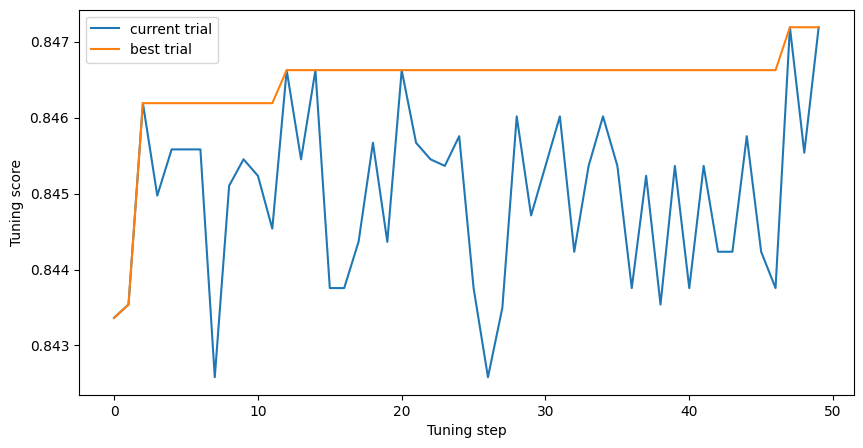

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()
pass

In [11]:
p = model_1.predict(test_ds)

#Fish for best cut
for cut in np.arange(0.25, .8, .05):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    N = len(p)
    for i in range(N):
        tru = test_cases[i]["label"] == '1'
        prd = p[i] > cut
        if tru and prd == tru:
            tp = tp + 1
        if tru and prd != tru:
            fn = fn + 1
        if tru == False and prd == tru:
            tn = tn + 1
        if tru == False and prd != tru:
            fp = fp + 1
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("cut: {}, acc: {}, prec: {}, rec: {}, f1: {}".format(cut, (tp+tn)/N, precision, recall, f1_score))

9/9 [==============================] - 2s 198ms/step
cut: 0.25, acc: 0.6446595229865192, prec: 0.420705261172921, rec: 0.9946500222915737, f1: 0.5913066525311423
cut: 0.3, acc: 0.7301532434612282, prec: 0.4890752593246524, rec: 0.9879625501560411, f1: 0.6542663123708297
cut: 0.35, acc: 0.7932941583131697, prec: 0.5570811085685228, rec: 0.9768167632634864, f1: 0.7095207253886009
cut: 0.39999999999999997, acc: 0.8432999193455467, prec: 0.6292069066432543, rec: 0.9585376727596968, f1: 0.7597173144876325
cut: 0.44999999999999996, acc: 0.8812075123862196, prec: 0.7057026476578412, rec: 0.9268836379848417, f1: 0.8013104644440162
cut: 0.49999999999999994, acc: 0.9079387026155087, prec: 0.786053882725832, rec: 0.8845296477931341, f1: 0.8323893434025591
cut: 0.5499999999999999, acc: 0.917732457656412, prec: 0.8511713367018833, rec: 0.8261257244761481, f1: 0.8384615384615385
cut: 0.5999999999999999, acc: 0.9119714252794101, prec: 0.9047619047619048, rec: 0.7369594293357111, f1: 0.812285012285012

In [15]:
cut = 55
N = len(p)
with open("/home/ralf//IdeaProjects/LitBall-training/pred.json", "w") as file:
    for c in np.arange(0., .5, .05):
        s = 0
        t = 0
        for i in range(N):
            tru = test_cases[i]["label"] == '1'
            val = int((p[i]+0.005) * 100)
            pred = False
            if val > cut:
                pred = True
            elif val > 100*c:
                s = s+1
                if tru:
                    t = t+1
        print("c: {}, n = {}, tru: {}".format(c, s, t))

c: 0.0, n = 6525, tru: 378
c: 0.05, n = 6396, tru: 378
c: 0.1, n = 5885, tru: 377
c: 0.15000000000000002, n = 4983, tru: 376
c: 0.2, n = 4009, tru: 374
c: 0.25, n = 3139, tru: 368
c: 0.30000000000000004, n = 2379, tru: 351
c: 0.35000000000000003, n = 1765, tru: 323
c: 0.4, n = 1261, tru: 281
c: 0.45, n = 785, tru: 209
